# Diplomatura en ciencia de datos, aprendizaje automático y sus aplicaciones - Edición 2023 - FAMAF (UNC)

## Mentoría 16 - ¿Cómo identificar fuga de ventas? Inteligencia artificial aplicada al sector comercial.

### Explorando Patrones de Datos a través de Clustering (TP3)

#### Parte 1: Preparación y análisis de los datos.

**Integrantes:**
- Canalis, Patricio.
- Chevallier-Boutell, Ignacio José.
- Villarroel Torrez, Daniel.

**Mentores:**
- Gonzalez, Lucía
- Lahoz, Nahuel

---
## Librerías

In [1]:
# Visualización y curación
import pandas as pd
import json
from os.path import exists
import missingno as msno
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Funciones propias
from tp2_utils_limpieza import * 
%load_ext autoreload
%autoreload 2

# Preferencias
pd.set_option('display.max_columns', 150)
pd.set_option('display.max_rows',150)
sns.set_context('talk')
sns.set_theme(style='white')

---
# Preparación de Datos

Se repiten los pasos de curación realizados en la entrega anterior. A tener en cuenta:
* Algunos pasos que se hacían por separado, ahora se hacen todos juntos. 
* No se simplifica la variable `Deposito`, ya que se descarta desde el principio.
* Hay un paso nuevo (el paso 9.), donde se mapean ciertos valores a $0.
* No se hace el cálculo de promedio y varianza de los vectores finales, ya que eso no se usa.

1. **Cargamos el dataset crudo.**

In [2]:
path = '../data/raw/tp2_muestra_diplodatos_ventas_omega_modelo_2023.csv'
ventas_raw = pd.read_csv(path)

/tmp/ipykernel_21074/1602723889.py:2: DtypeWarning: Columns (10,11,13) have mixed types. Specify dtype option on import or set low_memory=False.
  ventas_raw = pd.read_csv(path)


2. **Eliminamos las siguientes variables:**
    * `INSCRIPCION`.
    * `CATEGORIA`.
    * `DESCRIPCION_CATEGORIA`.
    * `CATEGORIA (Ajustado)`.
    * `NOMBRE`.
    * `CM04`.
    * `DESC_TRATAMIENTO_FISCAL`.
    * `TRATAMIENTO_DIFERNCIAL`.
    * `TRATAMIENTO_FISCAL`.
    * `PORCENTAJE_COMISION_EMPRESA`.
    * `DEPOSITO`.

In [3]:
ventas = limpiar_basic(ventas_raw, cols_drop=['INSCRIPCION', 'CATEGORIA', 'DESCRIPCION_CATEGORIA', 'CATEGORIA (Ajustado)', 
                                              'NOMBRE', 'CM04', 'DEPOSITO', 'DESC_TRATAMIENTO_FISCAL', 'TRATAMIENTO_DIFERNCIAL', 
                                              'TRATAMIENTO_FISCAL', 'PORCENTAJE_COMISION_EMPRESA'])

3. **Renombramos como `Otros` las subcategorías que no tengan al menos 1 `MODELO` = 1.**

In [4]:
ventas = renombrar_elementos(ventas, columna='SUB-CATEGORIA', 
                                     fill_otros='Otros')

4. **Eliminamos los registros que contienen las siguientes subcategorías:**
    * `Otros`.
    * `Instalación, Mantenimiento, Reparación, etc de productos varios` (a.k.a. `Mantenimiento`).

In [5]:
ventas = ventas[ventas['SUB-CATEGORIA'] != 'Otros'].copy()
ventas = ventas[ventas['SUB-CATEGORIA'] != 'Instalación, Mantenimiento, Reparación, etc de productos varios'].copy()

5. **Creamos la variable `Fecha` y eliminamos las variables `MES` y `AÑO`.**

In [6]:
ventas["Fecha"] = pd.to_datetime(ventas['MES'].astype(str) + '-' + ventas['AÑO'].astype(str), format='%m-%Y')
ventas = limpiar_basic(ventas, cols_drop=['MES', 'AÑO'])

6. **Anonimizamos la variable sensible `ID_VENDEDOR`.**

In [7]:
ventas, _ = anonimizar(ventas, 'ID_VENDEDOR')

Actualizando variable ID_VENDEDOR
	 Progreso >> 0%
	 Progreso >> 10%
	 Progreso >> 20%
	 Progreso >> 30%
	 Progreso >> 40%
	 Progreso >> 50%
	 Progreso >> 60%
	 Progreso >> 70%
	 Progreso >> 80%
	 Progreso >> 90%
	 Progreso >> 100%


7. **Simplificamos el nombre de las variables.**

In [8]:
with open("../dicts/tp2_column_dict.json") as column_dict_json:
    column_dict = json.load(column_dict_json)

ventas.rename(columns = column_dict, inplace = True)

8. **Simplificamos las categorías en `Subrubro`.**

In [9]:
with open("../dicts/tp2_subrubro_dict.json") as subrubro_dict_json:
    subrubro_dict = json.load(subrubro_dict_json)

ventas['Subrubro'] = ventas['Subrubro'].replace(subrubro_dict)

9. <span style="color:magenta">**(Este paso es nuevo)**</span> **Remplazamos con $0 a todas las ventas y comisiones que estén en el rango desde -$10.000 hasta $10.000.**

In [10]:
ventas[['Ventas', 'Comision']].describe()

,Ventas,Comision
count,3.706220e+05,3.706220e+05
mean,7.573558e+06,3.218162e+05
std,4.253813e+07,1.897839e+06
min,-1.052917e+08,-4.402579e+06
25%,0.000000e+00,0.000000e+00
50%,1.775391e+05,7.138745e+03
75%,3.705039e+06,1.539599e+05
max,4.876872e+09,2.438436e+08


Se trata de 152657 registros. De los cuales 143623 ya son idénticamente nulos.
Es decir que tenemos 9034 registros que no son nulos dentro de este rango ($-10000, $10000).
De los valores no nulos, hay 8704 positivos y 330 negativos.


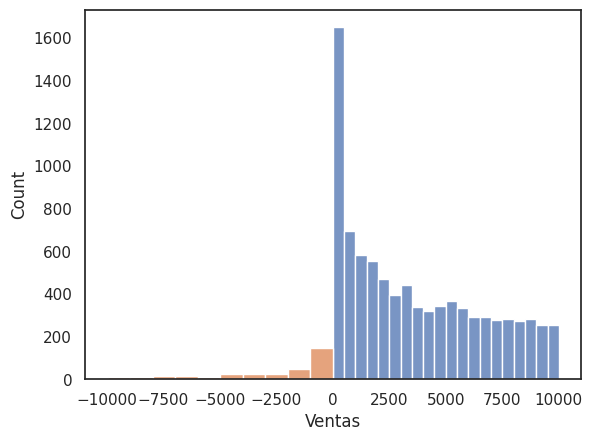

In [11]:
cut = 10000
a = ventas[(ventas['Ventas'] < cut) & (ventas['Ventas'] > - cut)].copy()
b = a[a['Ventas']==0].copy()
print(f'Se trata de {a.shape[0]} registros. De los cuales {b.shape[0]} ya son idénticamente nulos.')
print(f'Es decir que tenemos {a.shape[0] - b.shape[0]} registros que no son nulos dentro de este rango (${-cut}, ${cut}).')
c = a[a['Ventas'] != 0].copy()
cpos = c[c['Ventas']>0]
cneg = c[c['Ventas']<0]
print(f'De los valores no nulos, hay {cpos.shape[0]} positivos y {cneg.shape[0]} negativos.')

sns.histplot(cpos['Ventas'])
sns.histplot(cneg['Ventas'])
plt.show()

In [12]:
# Imputamos las ventas
ven = ventas['Ventas'].copy()
ven.mask((ven < cut) & (ven > - cut), inplace=True)
ven.fillna(0, inplace=True)
ventas['Ventas'] = ven

# Imputamos las comisiones
ven = ventas['Comision'].copy()
ven.mask((ven < cut) & (ven > - cut), inplace=True)
ven.fillna(0, inplace=True)
ventas['Comision'] = ven

10. **Eliminamos el efecto de la inflación.**

Este archivo ya existe.


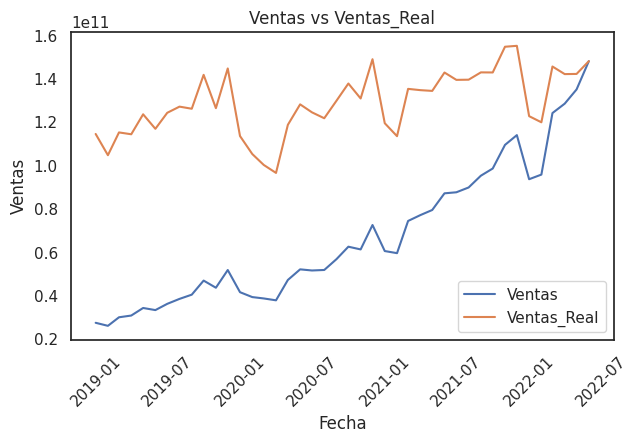

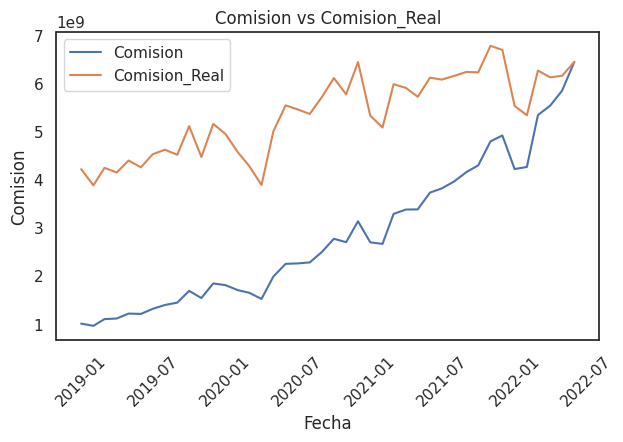

In [13]:
precios_path = "../data/external/tp2_IPC_Indec.csv"

if exists(precios_path):
    print('Este archivo ya existe.')
else:
    print('Este archivo no existe: ¡Vamos a crearlo!')
    url = "https://www.indec.gob.ar/ftp/cuadros/economia/sh_ipc_06_23.xls"
    df = pd.read_excel(url, sheet_name="Índices IPC Cobertura Nacional", header=None, usecols="B:CA", skiprows=[0, 1, 2, 3, 4, 6, 7, 8], nrows=2)
    df = df.transpose()
    df.columns = ["Fecha", "INDICE"]
    df["Fecha"] = pd.to_datetime(df["Fecha"])
    df.to_csv(precios_path, index=False)

precios = pd.read_csv(precios_path)
precios.columns = ["Fecha", "INDICE"]

# Hay que asegurar que la variable clave tenga el mismo tipo en los dos dataframes
precios["Fecha"] = pd.to_datetime(precios["Fecha"])

ventas = ventas.merge(precios[["Fecha", "INDICE"]], on="Fecha", how="left")

# Hacemos la imputación
indexar(ventas, 'Ventas')
indexar(ventas, 'Comision')

In [14]:
# Se descartan las variables que no se usan
ventas = limpiar_basic(ventas, cols_drop=['Ventas', 'Comision', 'INDICE'])

# Se renombran las variables
ventas.rename(columns = {'Ventas_Real': 'Ventas', 
                         'Comision_Real': 'Comision'}, inplace = True)

# Se reacomodan las columnas
ventas = ventas[['ID', 'Omega', 'Subrubro', 'Fecha', 'Ventas', 'Comision', 'Modelo']]

ventas = ventas.sort_values(['Fecha', 'Ventas']).reset_index(drop=True)

In [15]:
ventas.to_csv('../data/interim/tp3_ventas_antesdel11.csv', index=False)

11. **Pasar de ventas a vendedores**

    Para cada combinación posible de `Subrubro`, `ID` y `Fecha`, vamos a:
    * Sumar todos los valores de `Ventas`.
    * Sumar todos los valores de `Comision`.
    * Mantener los valores de `Modelo` y de `Omega`.

    Al hacer esto, se agregan en una única fila todas las observaciones que pertenezcan a un mismo vendedor en una dada fecha bajo un cierto subrubro.

In [16]:
agregado = ventas.groupby(['Subrubro', 'ID', 'Fecha']).agg({'Ventas': 'sum', 
                                                            'Comision': 'sum',
                                                            'Modelo': 'min',
                                                            'Omega': 'min'
                                                            }).reset_index()

12. **Se eliminan los registros asociados a vendedores que tienen siempre `Ventas` nulas dentro de un mismo `Subrubro`.**

In [17]:
agregado_no_nulo = agregado.groupby(['Subrubro', 'ID']).filter(lambda x: (x['Ventas'] != 0).any()).copy()

13. **Deberíamos tener 42 observaciones por par `ID`/`Subrubro`. Imputamos los meses faltantes con valor 0 en `Ventas` y en `Comision`.**

In [18]:
fechas_totales = set(agregado_no_nulo['Fecha'].sort_values().unique())

# Mostrar el promedio de observaciones por combinación de ID y Subrubro
promedio_observaciones = agregado_no_nulo.groupby(['Subrubro', 'ID']).size()
print(f'Cada vendedor tenía asociados ({promedio_observaciones.mean():.1f} +/- {promedio_observaciones.std():.1f}) meses diferentes en promedio.')

# Distinguimos los valores originales de los imputados (`Dato_original`).
agregado_no_nulo['Dato_original'] = 1

# Contar las observaciones por combinación de ID y Subrubro
conteo_combinaciones = agregado_no_nulo.groupby(['Subrubro', 'ID']).size().reset_index(name='Conteo')

# Filtrar las combinaciones con menos de 42 observaciones
combinaciones_faltantes = conteo_combinaciones[conteo_combinaciones['Conteo'] < 42]

# Lista para almacenar las observaciones faltantes
observaciones_faltantes = []

# Iterar sobre las combinaciones faltantes
for _, combinacion in combinaciones_faltantes.iterrows():
    id_val = combinacion['ID']
    subrubro_val = combinacion['Subrubro']
    
    # Obtener fechas existentes y fechas faltantes
    fechas_existentes = set(agregado_no_nulo[(agregado_no_nulo['ID'] == id_val) & (agregado_no_nulo['Subrubro'] == subrubro_val)]['Fecha'].unique())
    fechas_faltantes = fechas_totales - fechas_existentes

    # Agregar observaciones faltantes al DataFrame
    for fecha_faltante in fechas_faltantes:
        observacion = {
            'ID': id_val,
            'Subrubro': subrubro_val,
            'Fecha': fecha_faltante,
            'Ventas': 0,
            'Comision': 0,
        }
        observaciones_faltantes.append(observacion)

# Crear DataFrame con las observaciones faltantes
df_observaciones_faltantes = pd.DataFrame(observaciones_faltantes)

# Agregar observaciones faltantes al DataFrame agregado_no_nulo
agregado_limpio = pd.concat([agregado_no_nulo, df_observaciones_faltantes], ignore_index=True)

# Imputo los valores Omega y Modelo asociados a los nuevos meses adicionados. Es más eficiente agregarlo en una celda aparte y no en el for (antes demoraba 9 minutos, ahora menos de 1).
agregado_limpio['Omega'] = agregado_limpio.groupby(['ID', 'Subrubro'])['Omega'].transform('max')
agregado_limpio['Modelo'] = agregado_limpio.groupby(['ID', 'Subrubro'])['Modelo'].transform('max')

# Relleno los valores nulos de Dato_original con 0.
agregado_limpio['Dato_original'] = agregado_limpio['Dato_original'].fillna(0)

# Convertir las columnas 'Omega', 'Modelo' y 'Dato_original' a tipo int64
agregado_limpio['Omega'] = agregado_limpio['Omega'].astype('int64')
agregado_limpio['Modelo'] = agregado_limpio['Modelo'].astype('int64')
agregado_limpio['Dato_original'] = agregado_limpio['Dato_original'].astype('int64')

promedio_observaciones = agregado_limpio.groupby(['Subrubro', 'ID']).size()

# Mostrar el promedio de observaciones por combinación de ID y Subrubro
print(f'Cada vendedor tiene asociados ({promedio_observaciones.mean():.1f} +/- {promedio_observaciones.std():.1f}) meses diferentes en promedio.')

Cada vendedor tenía asociados (39.8 +/- 7.1) meses diferentes en promedio.
Cada vendedor tiene asociados (42.0 +/- 0.0) meses diferentes en promedio.


14. **Ordenar y guardar luego de todo lo que se hizo.**

In [19]:
# Dejar que primero esté Fecha. Sirve para el pivoteo que hacemos después.
registros_vendedores_abs = agregado_limpio.sort_values(['Fecha', 'Subrubro', 'ID']).reset_index(drop=True)

# Gurdamos el dataset
registros_vendedores_abs.to_csv('../data/interim/tp3_registros_vendedores_abs.csv', index=False)

15. **Reemplazar ceros por NaN**

    Queremos hacer el cálculo de la variación porcentual. Con el dataset como está actualmente (presencia de ceros), pueden generarse resultados que tienden a infinito. Para superar esta situación, se reemplazan todos los ceros por NaN.

In [20]:
registros_vendedores_rel = registros_vendedores_abs.copy()
registros_vendedores_rel[['Ventas', 'Comision']] = registros_vendedores_rel[['Ventas', 'Comision']].replace({0:np.NaN})

16. **Cálculo de cambios porcentuales.**

    **NOTA:** La función pct_change devuelve en el rango normal, no en el porcentual. 
    
    Ej: 1.0 significa 100% y no 1%.

In [21]:
crear_diferencia_porcentual(registros_vendedores_rel, 'Ventas', 12)
crear_diferencia_porcentual(registros_vendedores_rel, 'Comision', 12)
crear_diferencia_porcentual(registros_vendedores_rel, 'Ventas', 4)
crear_diferencia_porcentual(registros_vendedores_rel, 'Comision', 4)

17. **Pivotear los datos.**

In [22]:
pivotear = registros_vendedores_rel.copy()

# Extraer el mes y el año de la columna "Fecha"
pivotear["Fecha"] = pd.to_datetime(pivotear["Fecha"])
pivotear["Month"] = pivotear["Fecha"].dt.month
pivotear["Year"] = pivotear["Fecha"].dt.year

# Convertir "Month" a string con formato de dos cifras
pivotear["Month"] = pivotear["Month"].apply(lambda x: str(x).zfill(2))

# Convertir "Year" a string y quedarse con los últimos 2 dígitos
pivotear["Year"] = pivotear["Year"].apply(lambda x: str(x)[-2:])

# Crear la variable "Fecha2" que concatena "Year" y "Month"
pivotear["Fecha2"] = pivotear["Year"] + pivotear["Month"]

# Eliminar columnas
pivotear.drop(columns=['Fecha','Ventas','Comision','Dato_original','Month','Year'], inplace=True)

# Renombrar la columnas
pivotear.rename(columns={'Fecha2': 'Fecha', 'Y_pct_Ventas': 'Y_pct_Ven', 'Y_pct_Comision': 'Y_pct_Com', 'F_pct_Ventas': 'F_pct_Ven', 'F_pct_Comision': 'F_pct_Com'}, inplace=True)

In [23]:
# Realizar el pivoteo y la agrupación
pivot_df = pivotear.pivot_table(index=["ID",'Subrubro','Omega','Modelo'], columns=['Fecha'], values=['Y_pct_Ven', 'Y_pct_Com', 'F_pct_Ven', 'F_pct_Com'])

# Generar los nombres de las columnas finales
columns = [f"{col[0]}_{col[1]}" for col in pivot_df.columns]

# Asignar los nuevos nombres de columnas
pivot_df.columns = columns

# Restablecer el índice para que "ID" vuelva a ser una columna
pivot_df = pivot_df.reset_index()

18. **Guaradamos el dataset pivoteado.**

In [24]:
pivot_df.to_csv('../data/interim/tp3_vendedores_vector.csv', index=False)

---
# Análisis del dataset antes de hacer agregaciones y pivotearlo

Queremos ver con qué nos quedamos ahora.

## Análisis de variables categóricas: `Subrubro` vs `Modelo`

Para algunos ID se asignan diferentes valores de Subrubro:
ID
1474    10
1416     9
1987     9
1525     9
1089     9
        ..
1352     2
1353     2
1355     2
1360     2
3134     2
Name: Subrubro, Length: 1458, dtype: int64


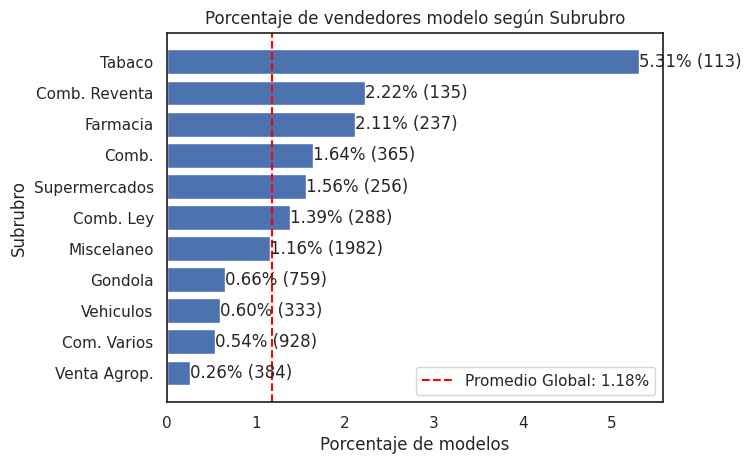

In [25]:
checkear_unicidad(ventas, 'Subrubro', 'ID')
graficar_modelo(ventas, 'Subrubro')

## Análisis de variables numéricas

In [26]:
ventas[['Ventas', 'Comision']].describe()

,Ventas,Comision
count,3.706220e+05,3.706220e+05
mean,1.459124e+07,6.064590e+05
std,7.432475e+07,3.227135e+06
min,-3.475437e+08,-1.216403e+07
25%,0.000000e+00,0.000000e+00
50%,3.936936e+05,0.000000e+00
75%,8.060644e+06,3.353994e+05
max,6.894934e+09,3.447467e+08


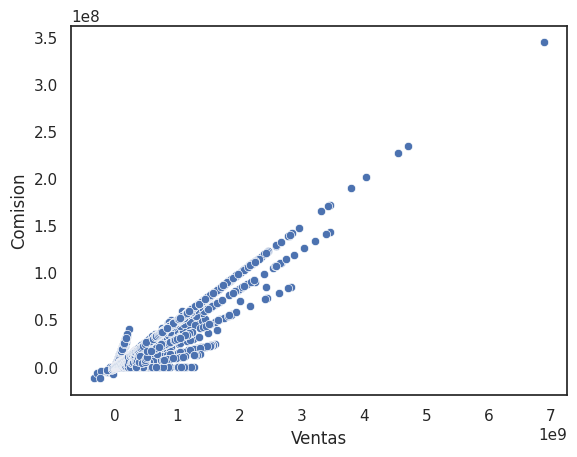

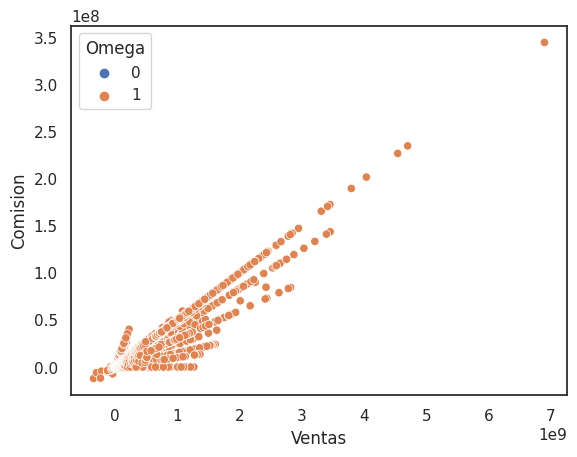

/home/cheva/.local/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


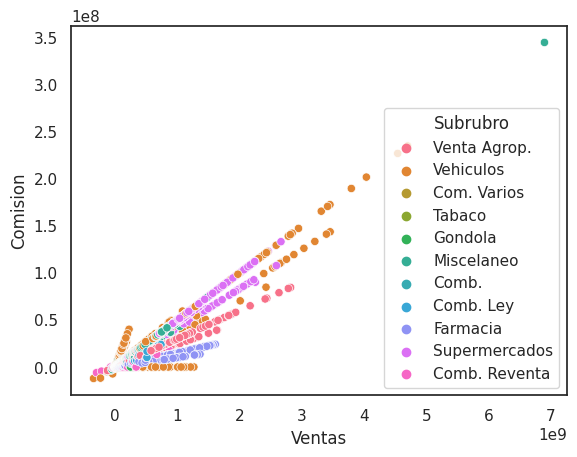

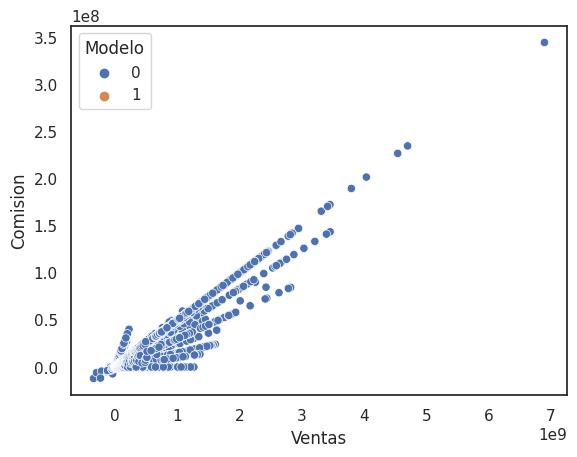

In [27]:
sns.scatterplot(data=ventas[['Ventas', 'Comision']], x='Ventas', y='Comision')
plt.show()

# Estas gráficas tardan bastante en generarse, descomentar para obtenerlas

for col in ['Omega', 'Subrubro', 'Modelo']:
    sns.scatterplot(data=ventas[['Ventas', 'Comision',col]], x='Ventas', y='Comision', hue=col)
    plt.show()

## Análisis de la serie temporal

En todos los subrurbos vemos que hay modelos y no modelo, incluso si exluimos las ventas nulas.

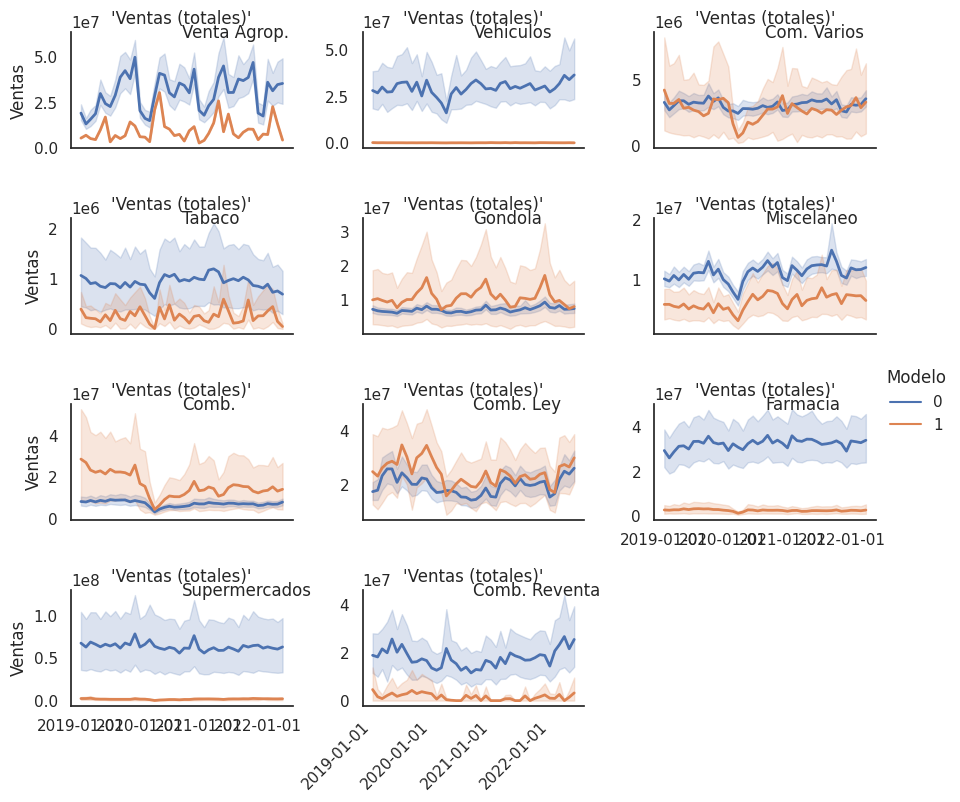

In [28]:
g = sns.relplot(
    data=ventas,
    x="Fecha", y="Ventas", col="Subrubro", hue="Modelo",
    kind="line", linewidth=2, zorder=5,
    col_wrap=3, height=2, aspect=1.5, legend=True,
    facet_kws=dict(sharey=False)
)

# Iterate over each subplot to customize further
for subrubro, ax in g.axes_dict.items():

    # Add the title as an annotation within the plot
    ax.text(.5, .95, subrubro, transform=ax.transAxes)

# Reduce the frequency of the x axis ticks
ax.set_xticks(ax.get_xticks()[::2])
#ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
plt.xticks(rotation=45, ha='right')

g.set_titles("'Ventas (totales)'")
g.set_axis_labels("", "Ventas")    
#g.tight_layout()

plt.show()

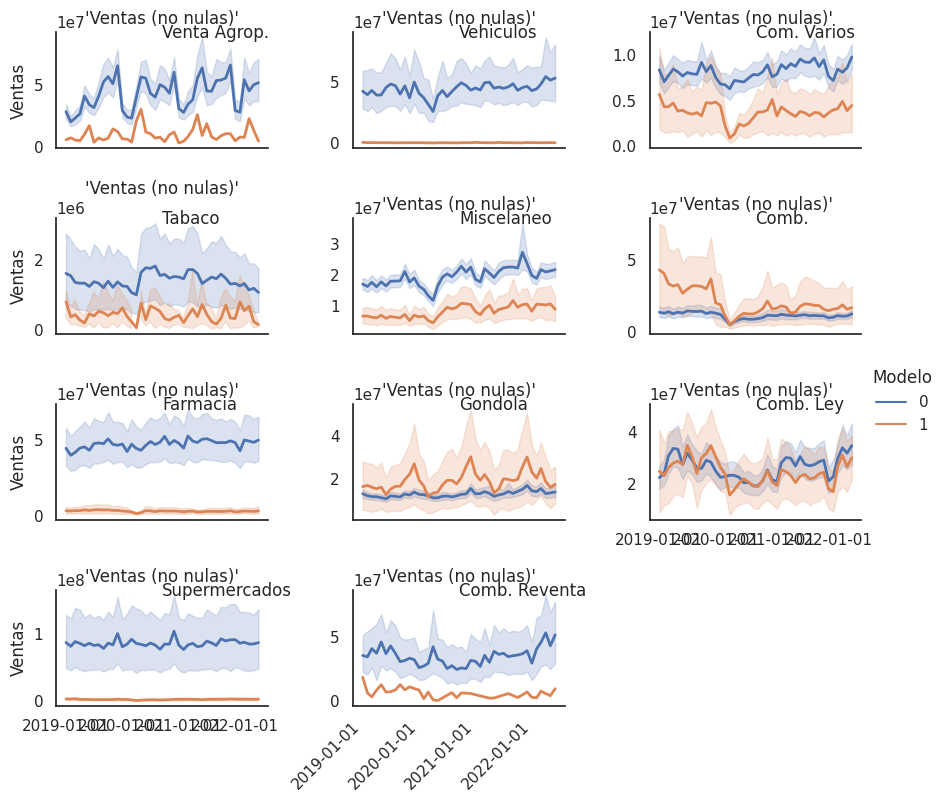

In [29]:
g = sns.relplot(
    data=ventas[ventas['Ventas'] != 0],
    x="Fecha", y="Ventas", col="Subrubro", hue="Modelo",
    kind="line", linewidth=2, zorder=5,
    col_wrap=3, height=2, aspect=1.5, legend=True,
    facet_kws=dict(sharey=False)
)

# Iterate over each subplot to customize further
for subrubro, ax in g.axes_dict.items():

    # Add the title as an annotation within the plot
    ax.text(.5, .95, subrubro, transform=ax.transAxes)

# Reduce the frequency of the x axis ticks
ax.set_xticks(ax.get_xticks()[::2])
#ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
plt.xticks(rotation=45, ha='right')

g.set_titles("'Ventas (no nulas)'")
g.set_axis_labels("", "Ventas")    
#g.tight_layout()

plt.show()

---
# Datasets pivoteados: tp2 vs tp3

Vamos a comparar el dataset pivoteado que generamos al final del tp2 con el dataset pivoteado que generamos ahora, cuya principal diferencia es el punto 9 del pretratamiento: remplazamos con $0 a todas las ventas y comisiones que estaban en el rango desde -$10.000 hasta $10.000.

In [30]:
tp2 = pd.read_csv('../data/interim/tp2_vendedores_vector_resumen.csv')
tp2 = limpiar_basic(tp2, cols_drop=['Omega', 'F_ven_mean', 'F_ven_var', 
                                    'F_com_mean', 'F_com_var', 'Y_ven_mean', 
                                    'Y_ven_var', 'Y_com_mean', 'Y_com_var'])

tp3 = pd.read_csv('../data/interim/tp3_vendedores_vector.csv')
tp3 = limpiar_basic(tp3, cols_drop='Omega')

Las filas de estos datasets representaban un vendedor único, dado el subrubro. Esto implica que un mismo `ID` puede aparecer más de una vez, pero es porque ese vendedor vende en dos o más `Subrubros`.

In [31]:
print(f'El del tp2 tenía {tp2.shape[0]} filas, mientras que el nuevo tiene {tp3.shape[0]}.')
print(f'Hay {tp2.shape[0] - tp3.shape[0]} menos.')

El del tp2 tenía 4616 filas, mientras que el nuevo tiene 4544.
Hay 72 menos.


## Sin diferenciar por subrubro

En la siguiente figura se grafican las medias con sus respectivas desviaciones estándares para cada variable porcentual. Vemos que, al haber agregado este paso nuevo en el pretratamiento, los datos son muchísimo menos ruidosos.

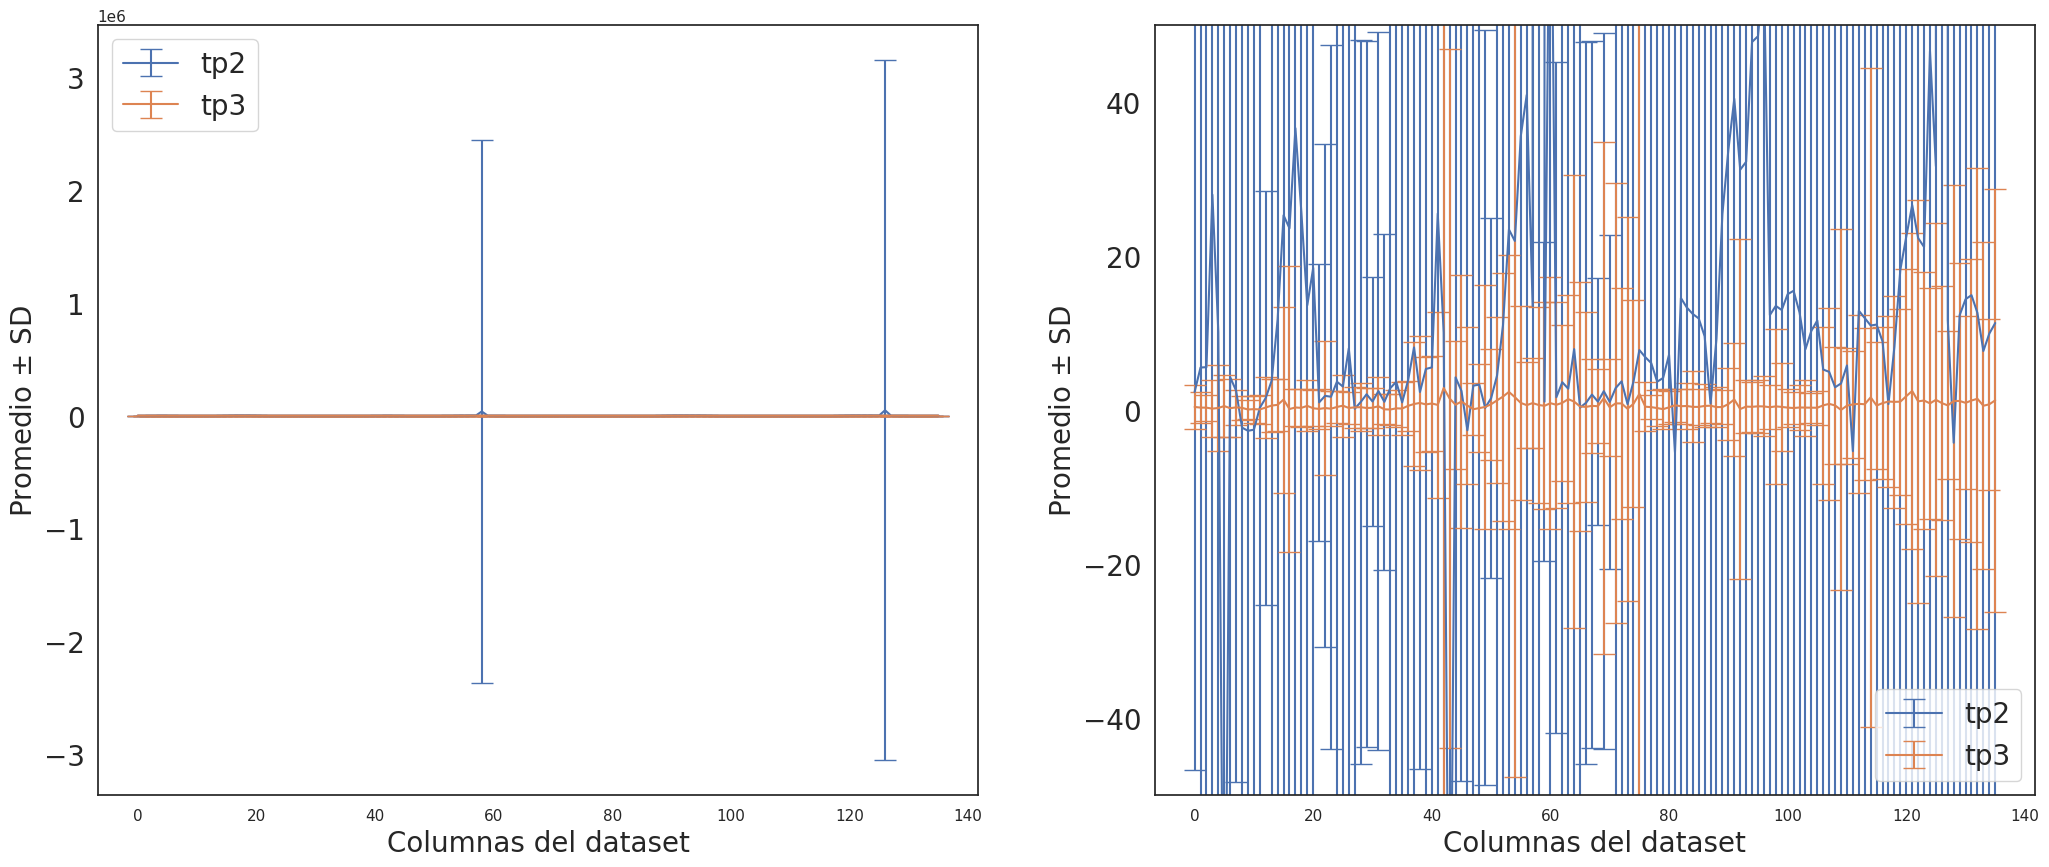

In [32]:
fig, axs = plt.subplots(1, 2, figsize=(25, 10))

axs[0].errorbar(range(len(tp2.iloc[:, 3:].mean())), tp2.iloc[:, 3:].mean(), yerr = tp2.iloc[:, 3:].std(), capsize = 8, label='tp2')
axs[0].errorbar(range(len(tp3.iloc[:, 3:].mean())), tp3.iloc[:, 3:].mean(), yerr = tp3.iloc[:, 3:].std(), capsize = 8, label='tp3')
axs[0].set_ylabel(r'Promedio $\pm$ SD', fontsize=20)
axs[0].tick_params(axis='y', labelsize=20)
axs[0].legend(fontsize=20)
axs[0].set_xlabel('Columnas del dataset', fontsize=20)

axs[1].errorbar(range(len(tp2.iloc[:, 3:].mean())), tp2.iloc[:, 3:].mean(), yerr = tp2.iloc[:, 3:].std(), capsize = 8, label='tp2')
axs[1].errorbar(range(len(tp3.iloc[:, 3:].mean())), tp3.iloc[:, 3:].mean(), yerr = tp3.iloc[:, 3:].std(), capsize = 8, label='tp3')
axs[1].set_ylabel(r'Promedio $\pm$ SD', fontsize=20)
axs[1].tick_params(axis='y', labelsize=20)
axs[1].legend(fontsize=20)
axs[1].set_ylim(-50, 50)
axs[1].set_xlabel('Columnas del dataset', fontsize=20)

plt.show()

Al comparar entre valores promedios, vemos que hay dos variables cuyo promedio ha bajado drásticamente. Para el resto, en general ha bajado en la mayoría de los casos, salvo algunos donde ha subido.

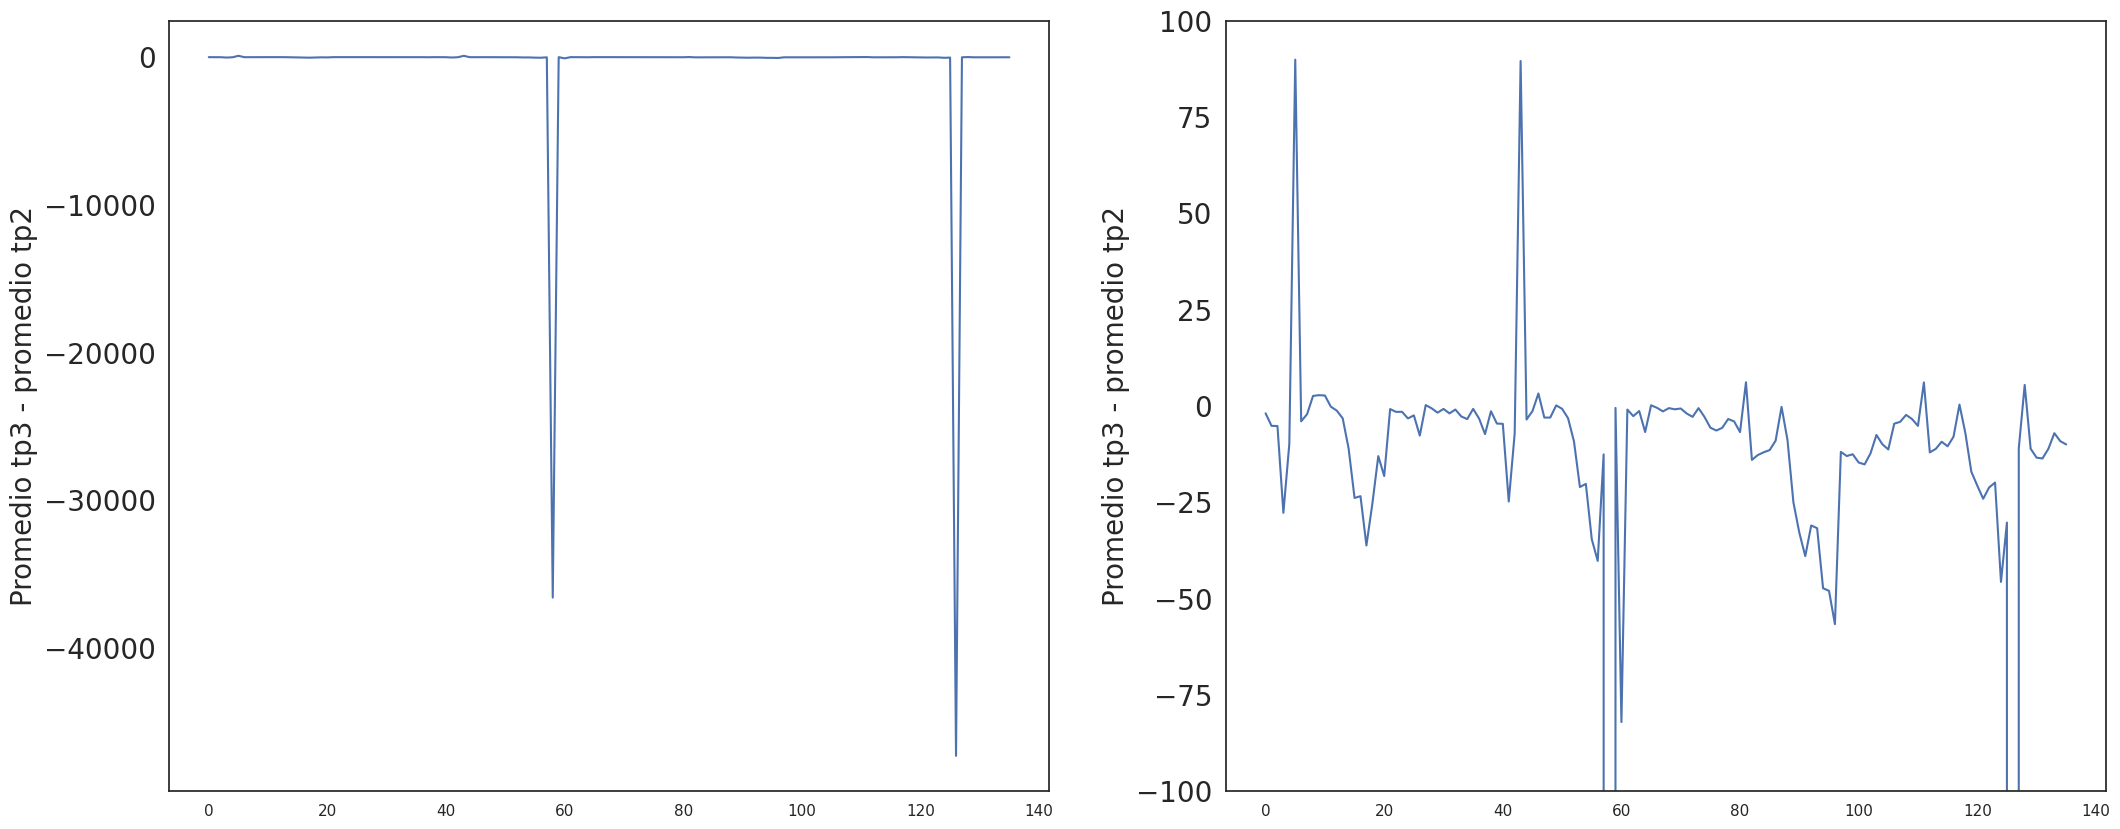

In [33]:
fig, axs = plt.subplots(1, 2, figsize=(25, 10))

axs[0].plot(range(len(tp3.iloc[:, 3:].mean())), tp3.iloc[:, 3:].mean() - tp2.iloc[:, 3:].mean())
axs[0].set_ylabel(r'Promedio tp3 - promedio tp2', fontsize=20)
axs[0].tick_params(axis='y', labelsize=20)

axs[1].plot(range(len(tp3.iloc[:, 3:].mean())), tp3.iloc[:, 3:].mean() - tp2.iloc[:, 3:].mean())
axs[1].set_ylabel(r'Promedio tp3 - promedio tp2', fontsize=20)
axs[1].tick_params(axis='y', labelsize=20)
axs[1].set_ylim(-100, 100)

plt.show()

Veamos cuáles eran los órdenes de magnitud de valores más extremos a lo largo de todo el dataset. Antes las variaciones porcentuales cubrían 13 órdenes de magnitud, mientras que ahora ocupan 6.

In [34]:
print('TP2:')
print(f'\t El mínimo era {np.min(tp2.iloc[:, 3:].min()):.2e}')
print(f'\t El máximo era {np.max(tp2.iloc[:, 3:].max()):.2e}')

print('TP3:')
print(f'\t El mínimo es {np.min(tp3.iloc[:, 3:].min()):.2e}')
print(f'\t El máximo es {np.max(tp3.iloc[:, 3:].max()):.2e}')

TP2:
	 El mínimo era -3.82e+05
	 El máximo era 2.04e+08
TP3:
	 El mínimo es -1.47e+03
	 El máximo es 9.62e+03


## Diferenciando por subrubro

Al desagregar por subrubro, se sigue manteniendo el hecho de que los datos son muchísimo menos ruidosos ahora. Sin embargo, se ve que algunos subrubros presentan una mayor variación entre el tp2 y tp3 que otros: 'Farmacia', 'Comb.', 'Vehiculos', 'Tabaco' y 'Comb. Reventa' presentan las variaciones más leves.

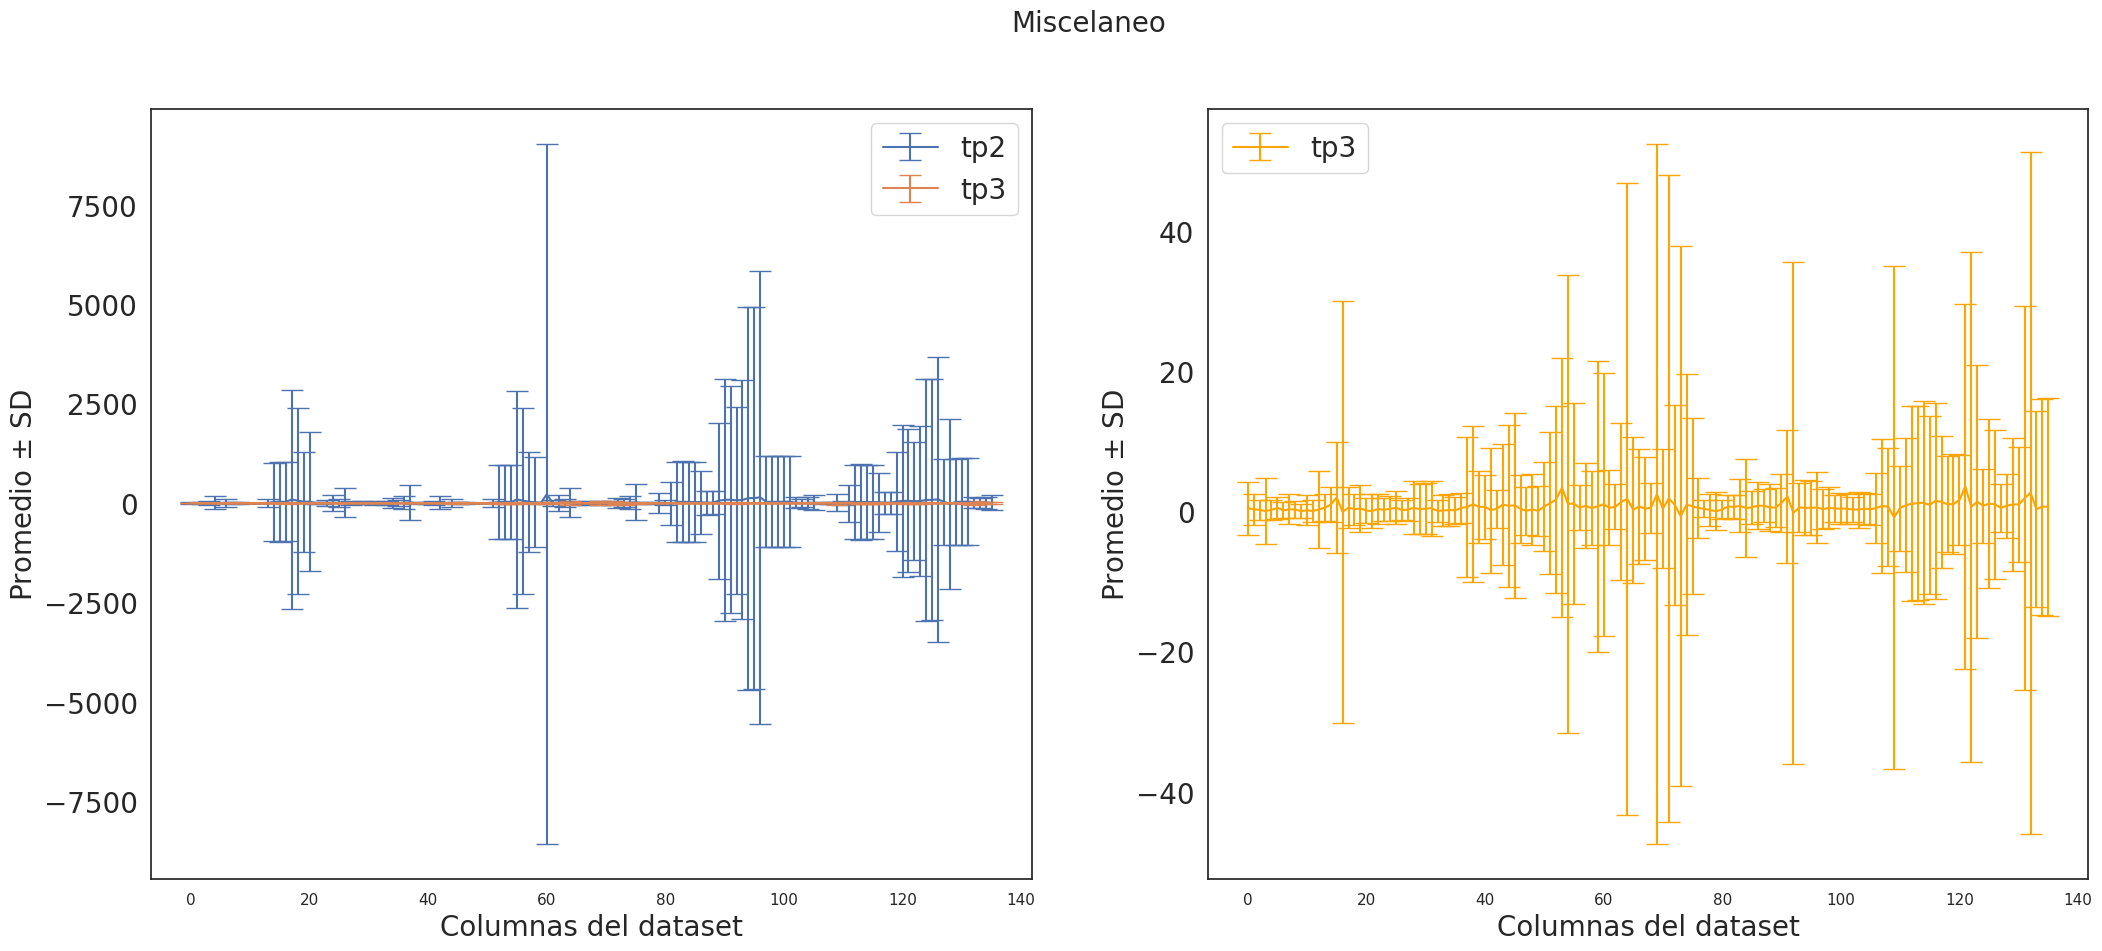

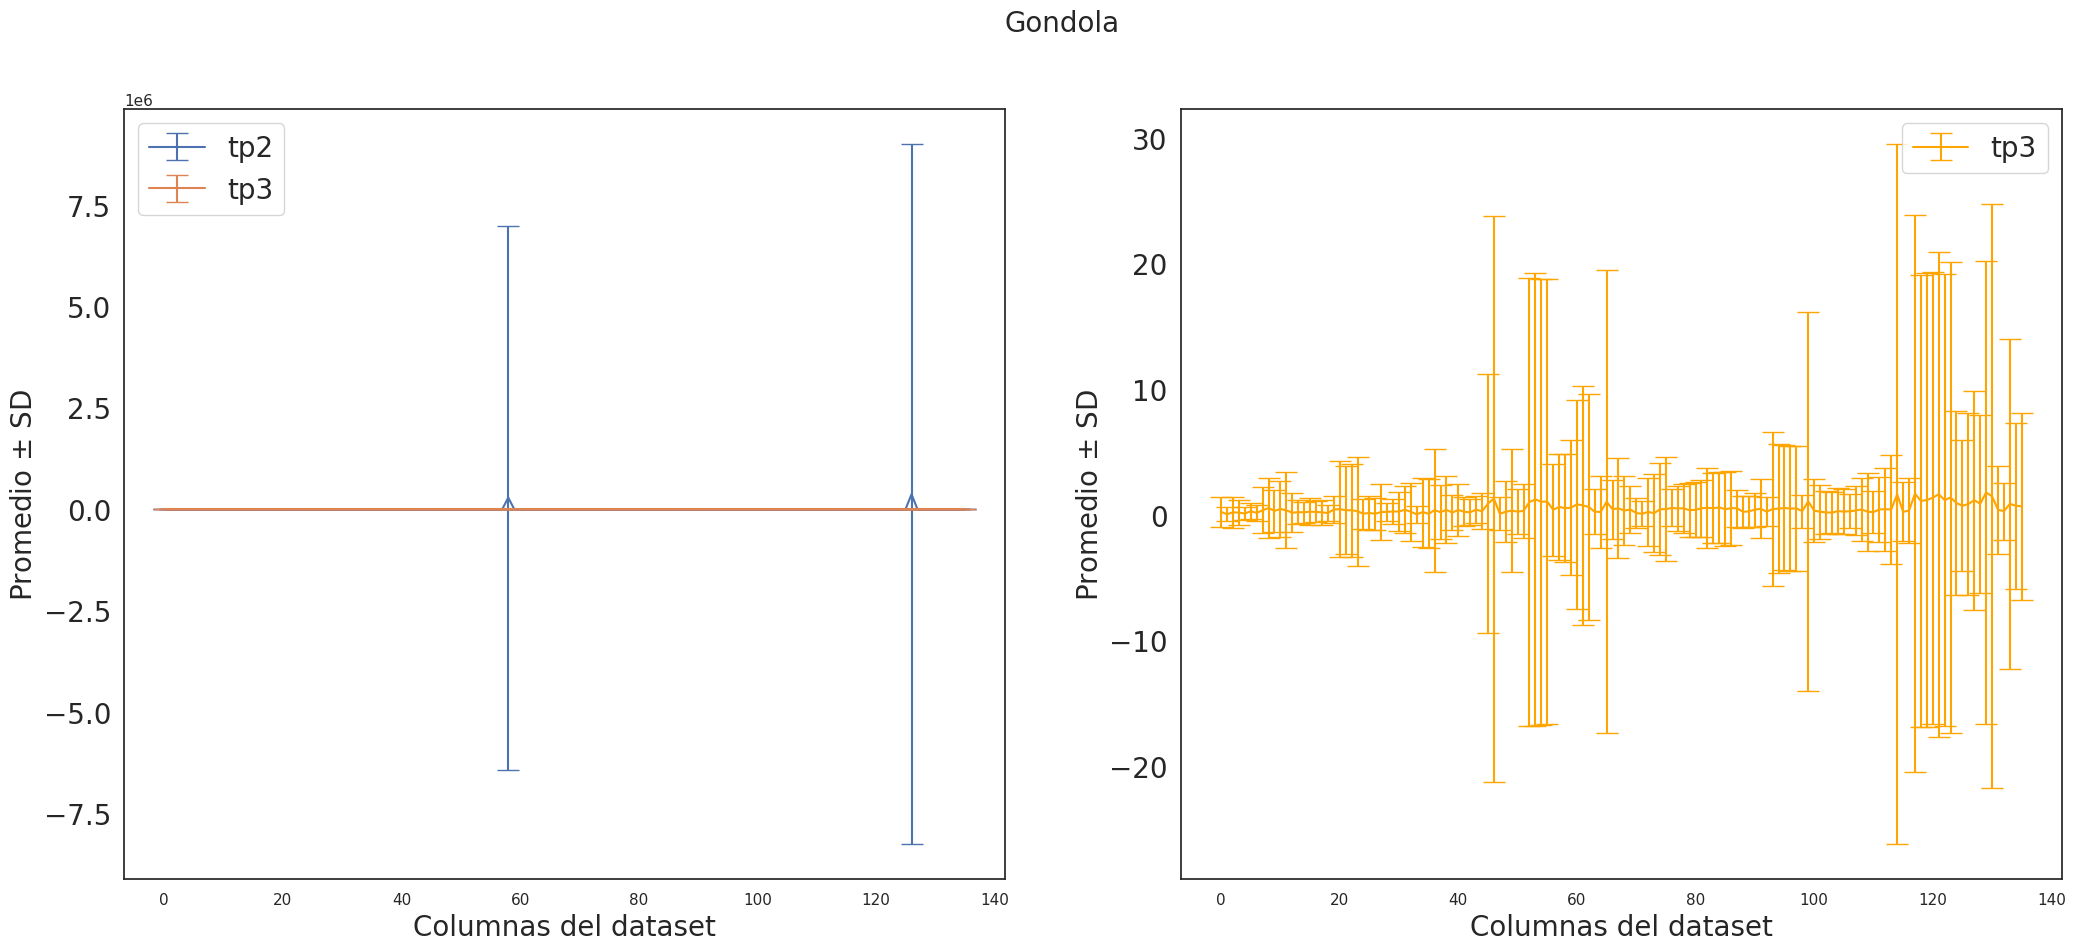

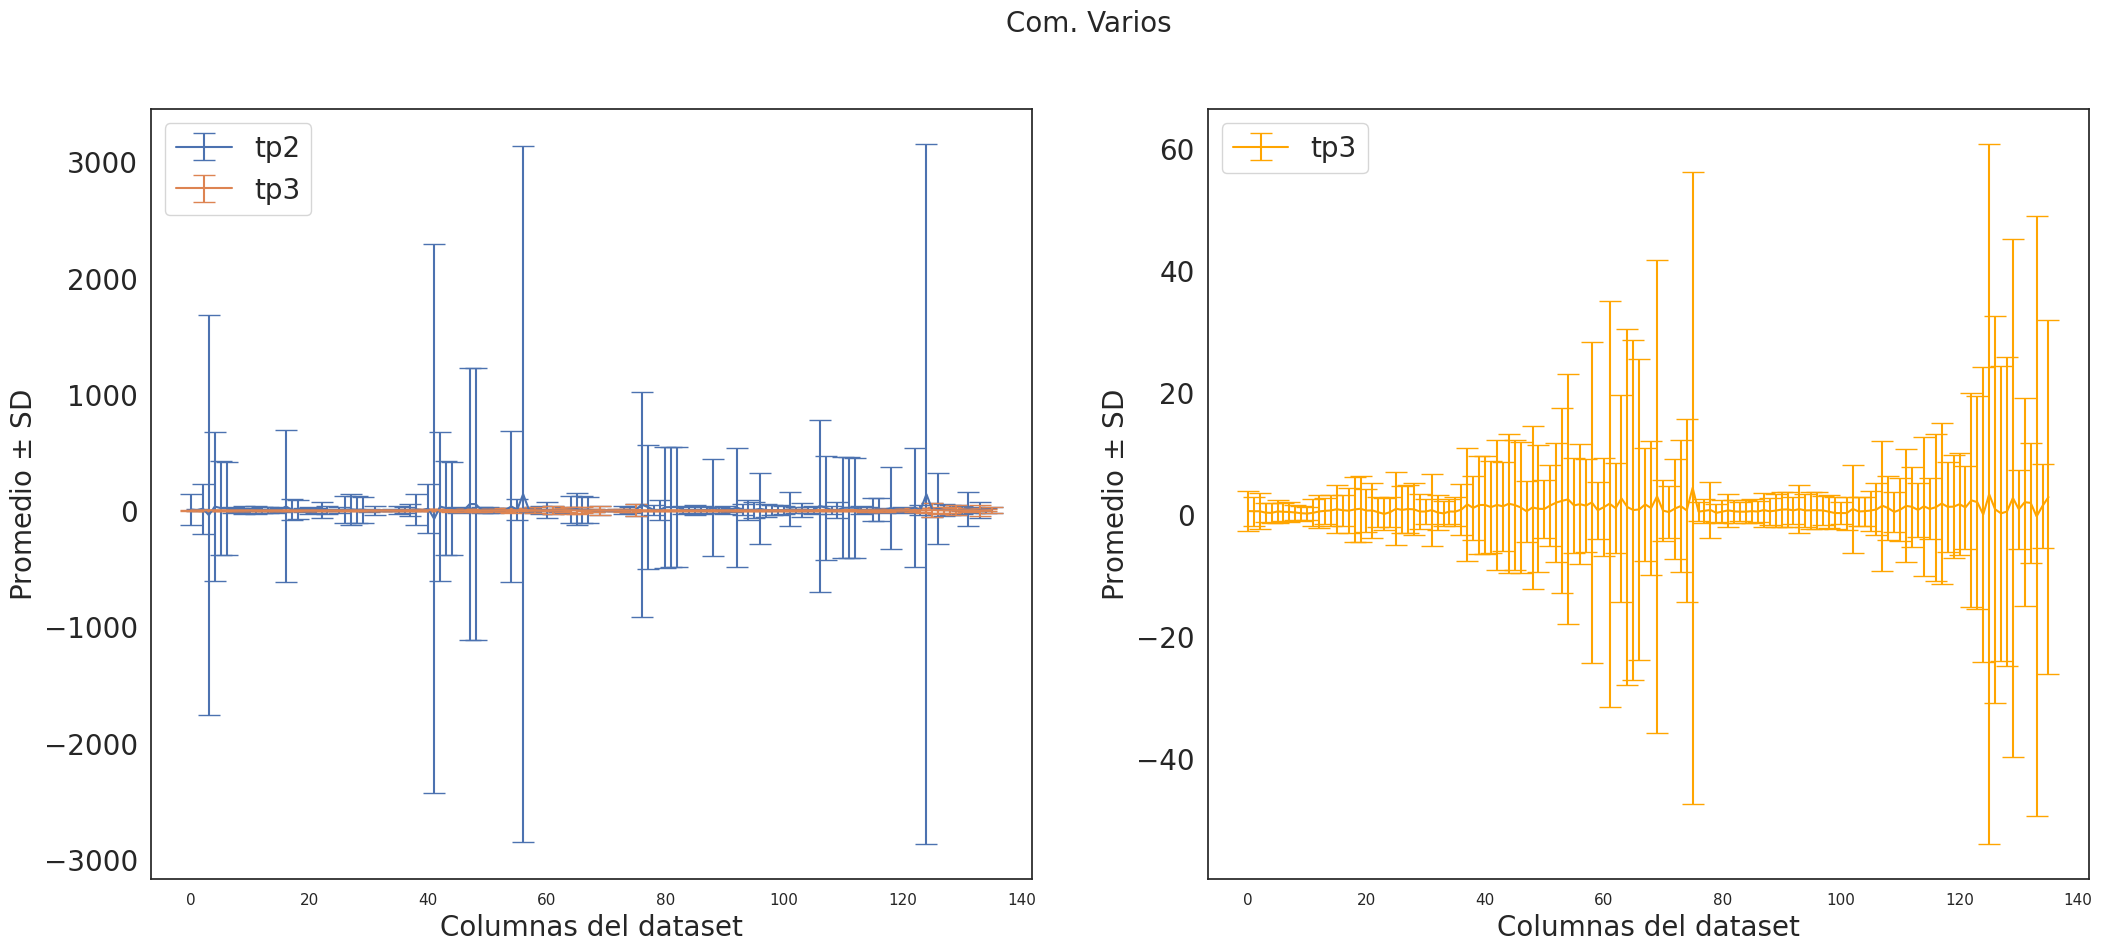

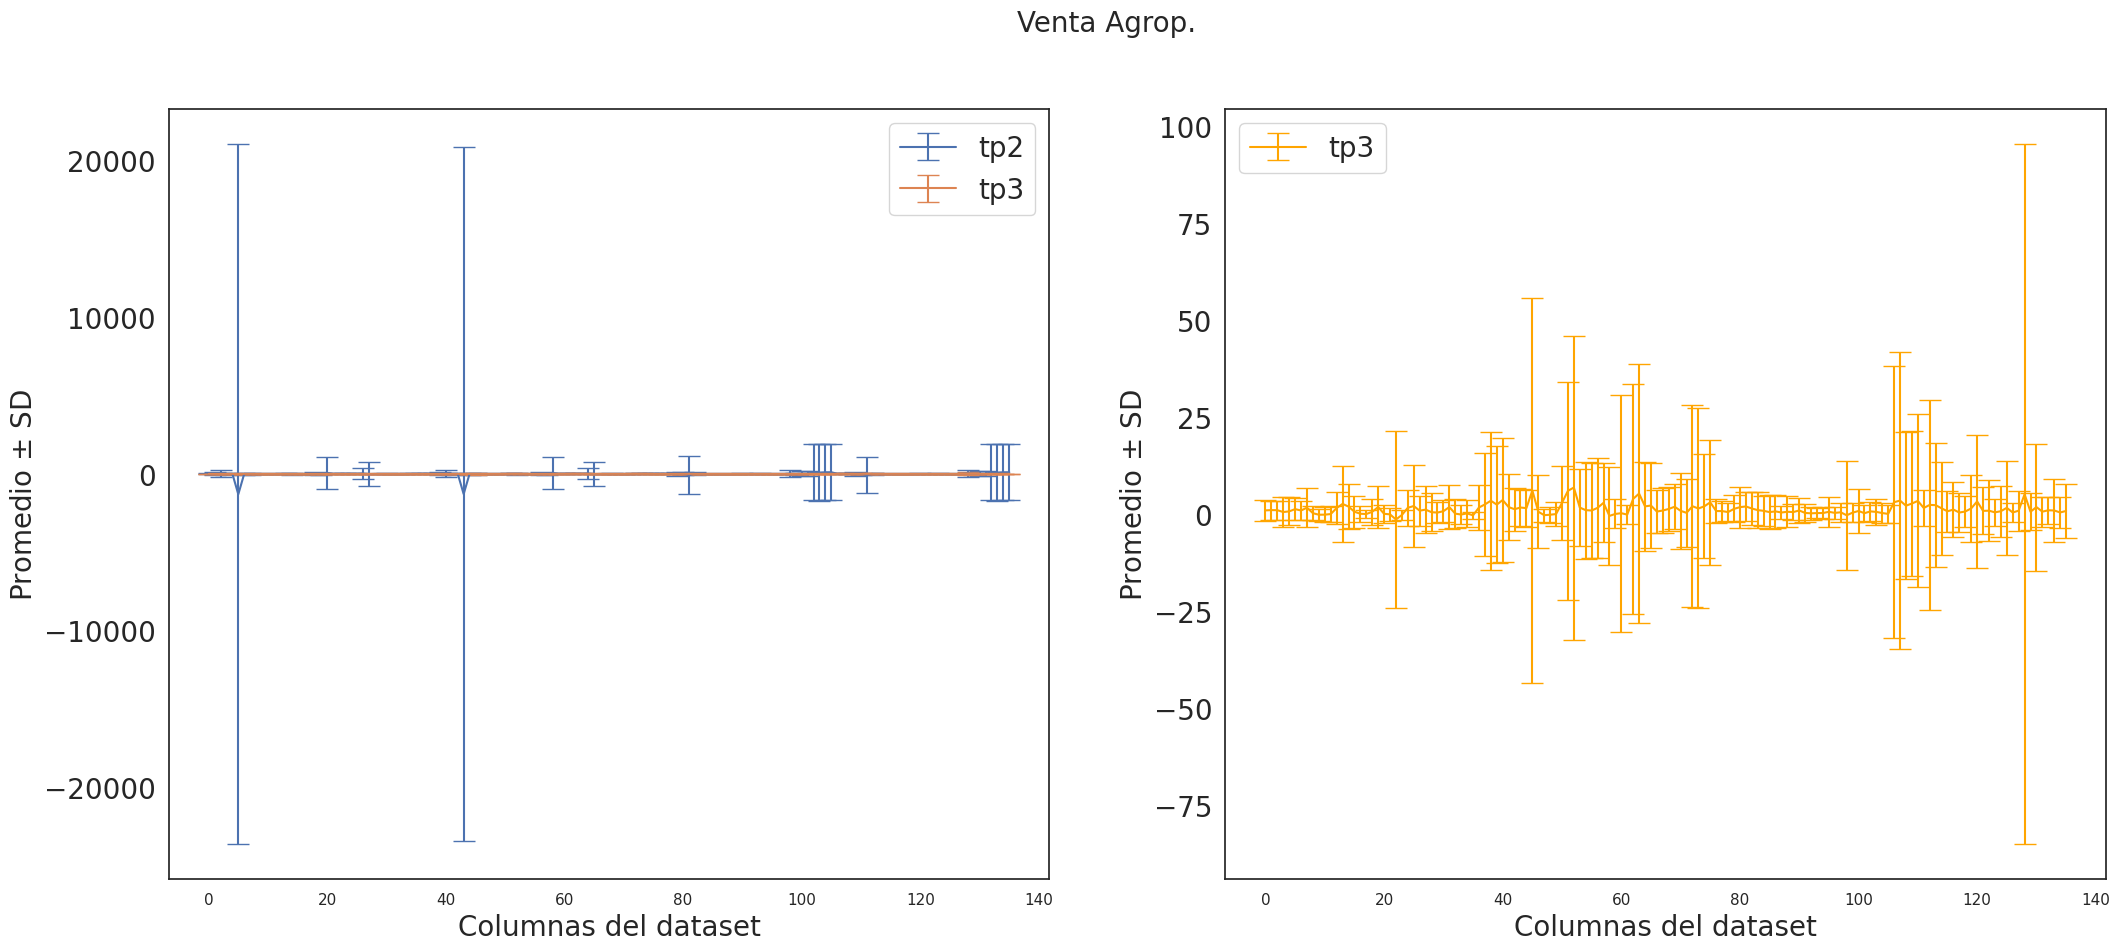

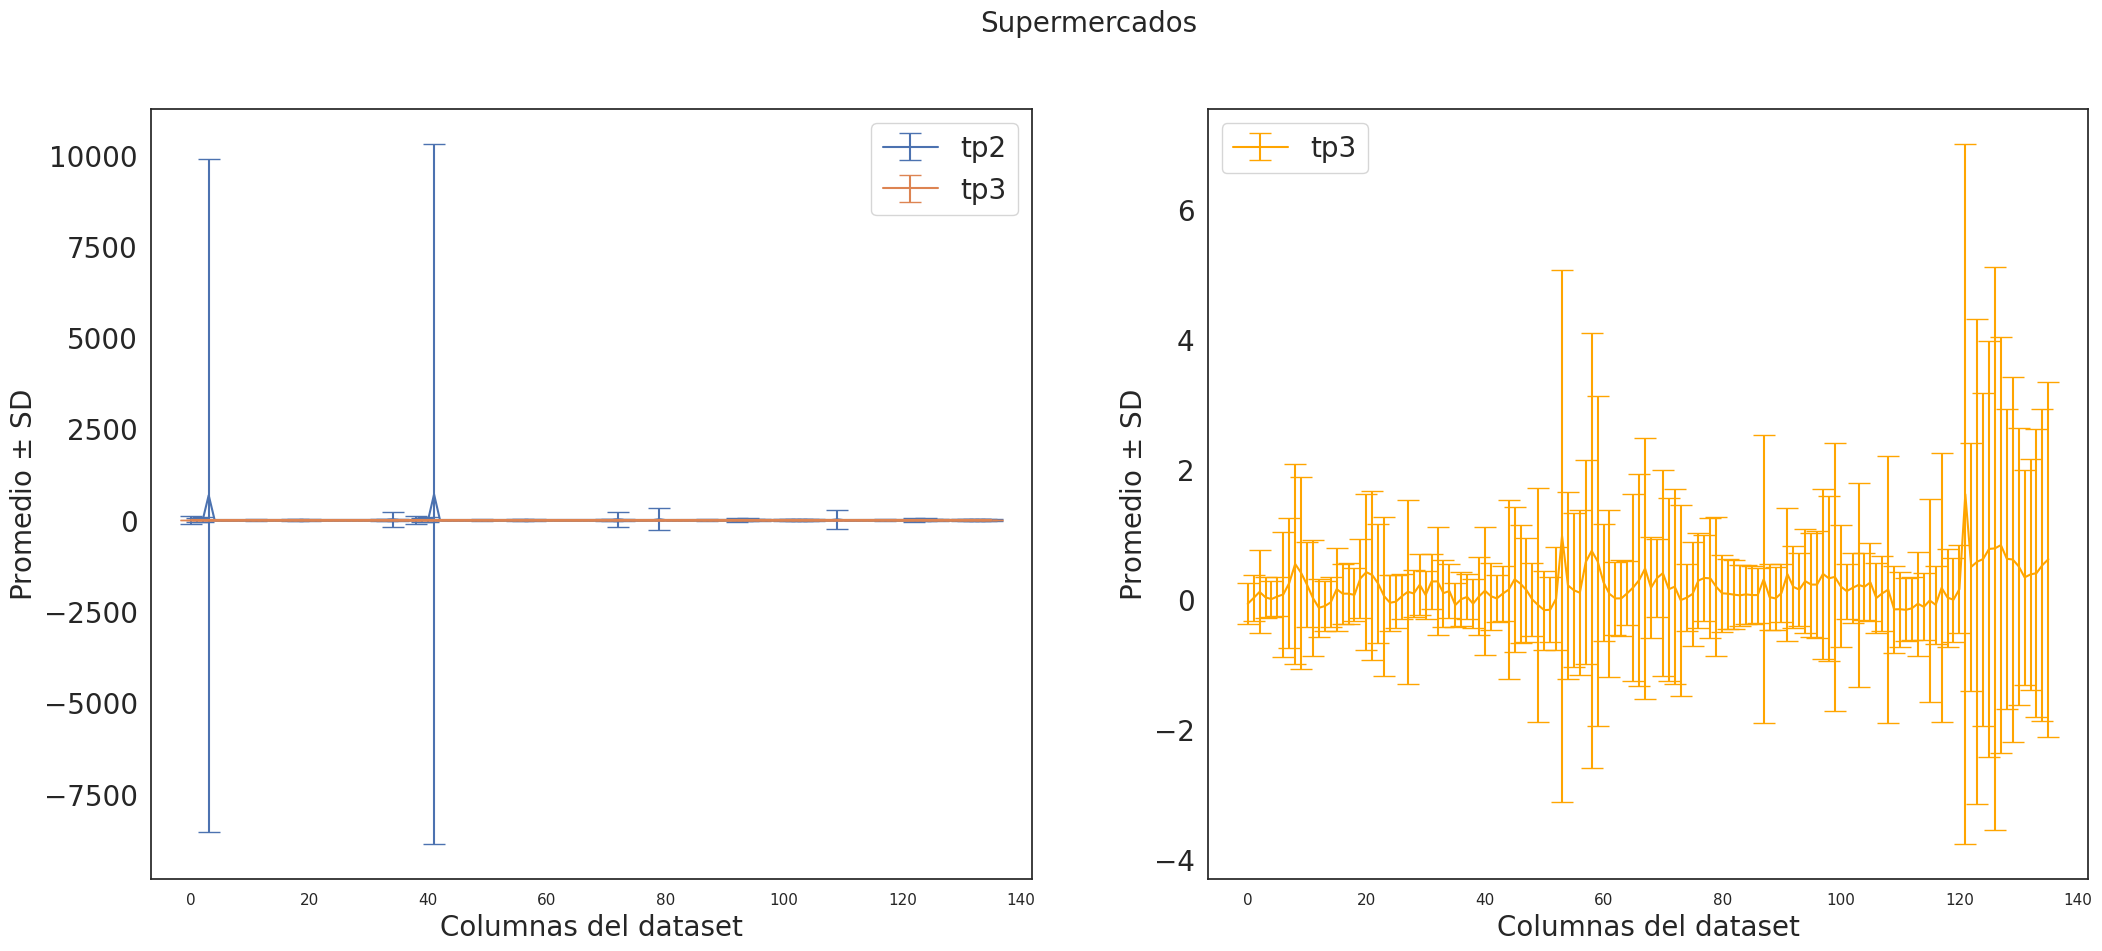

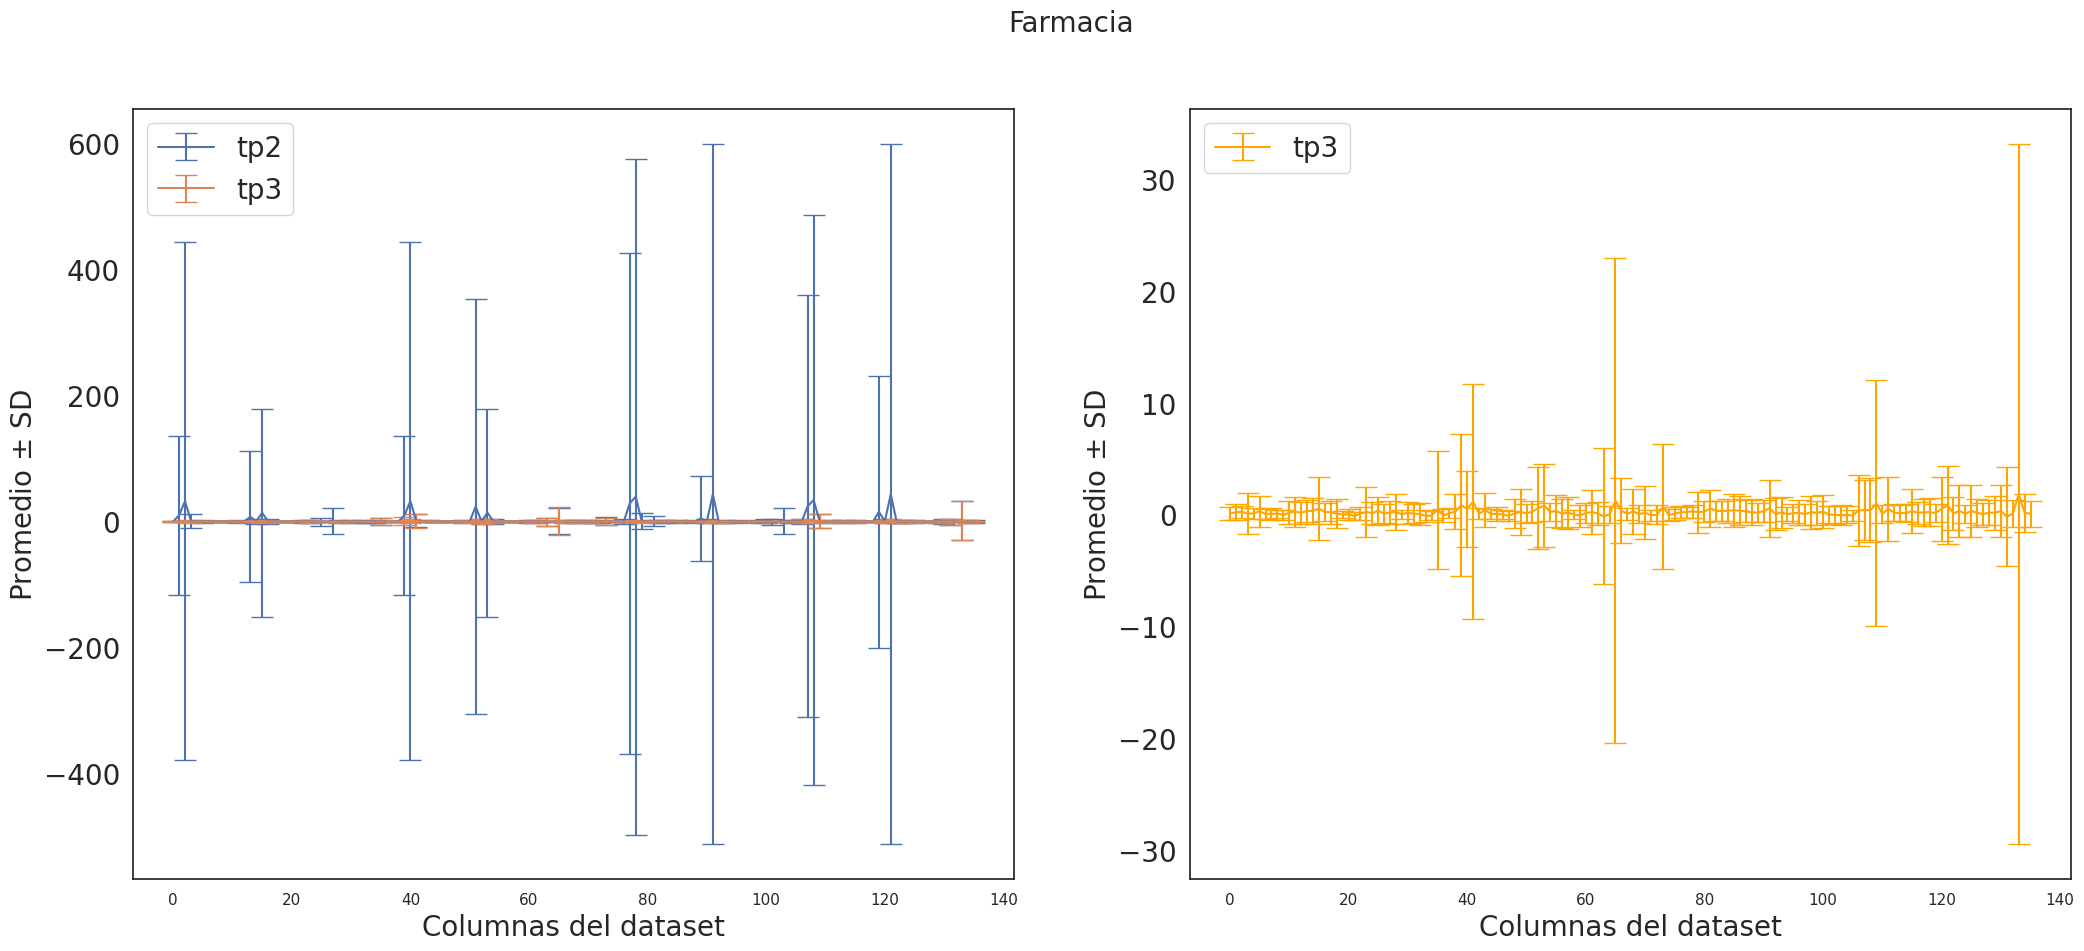

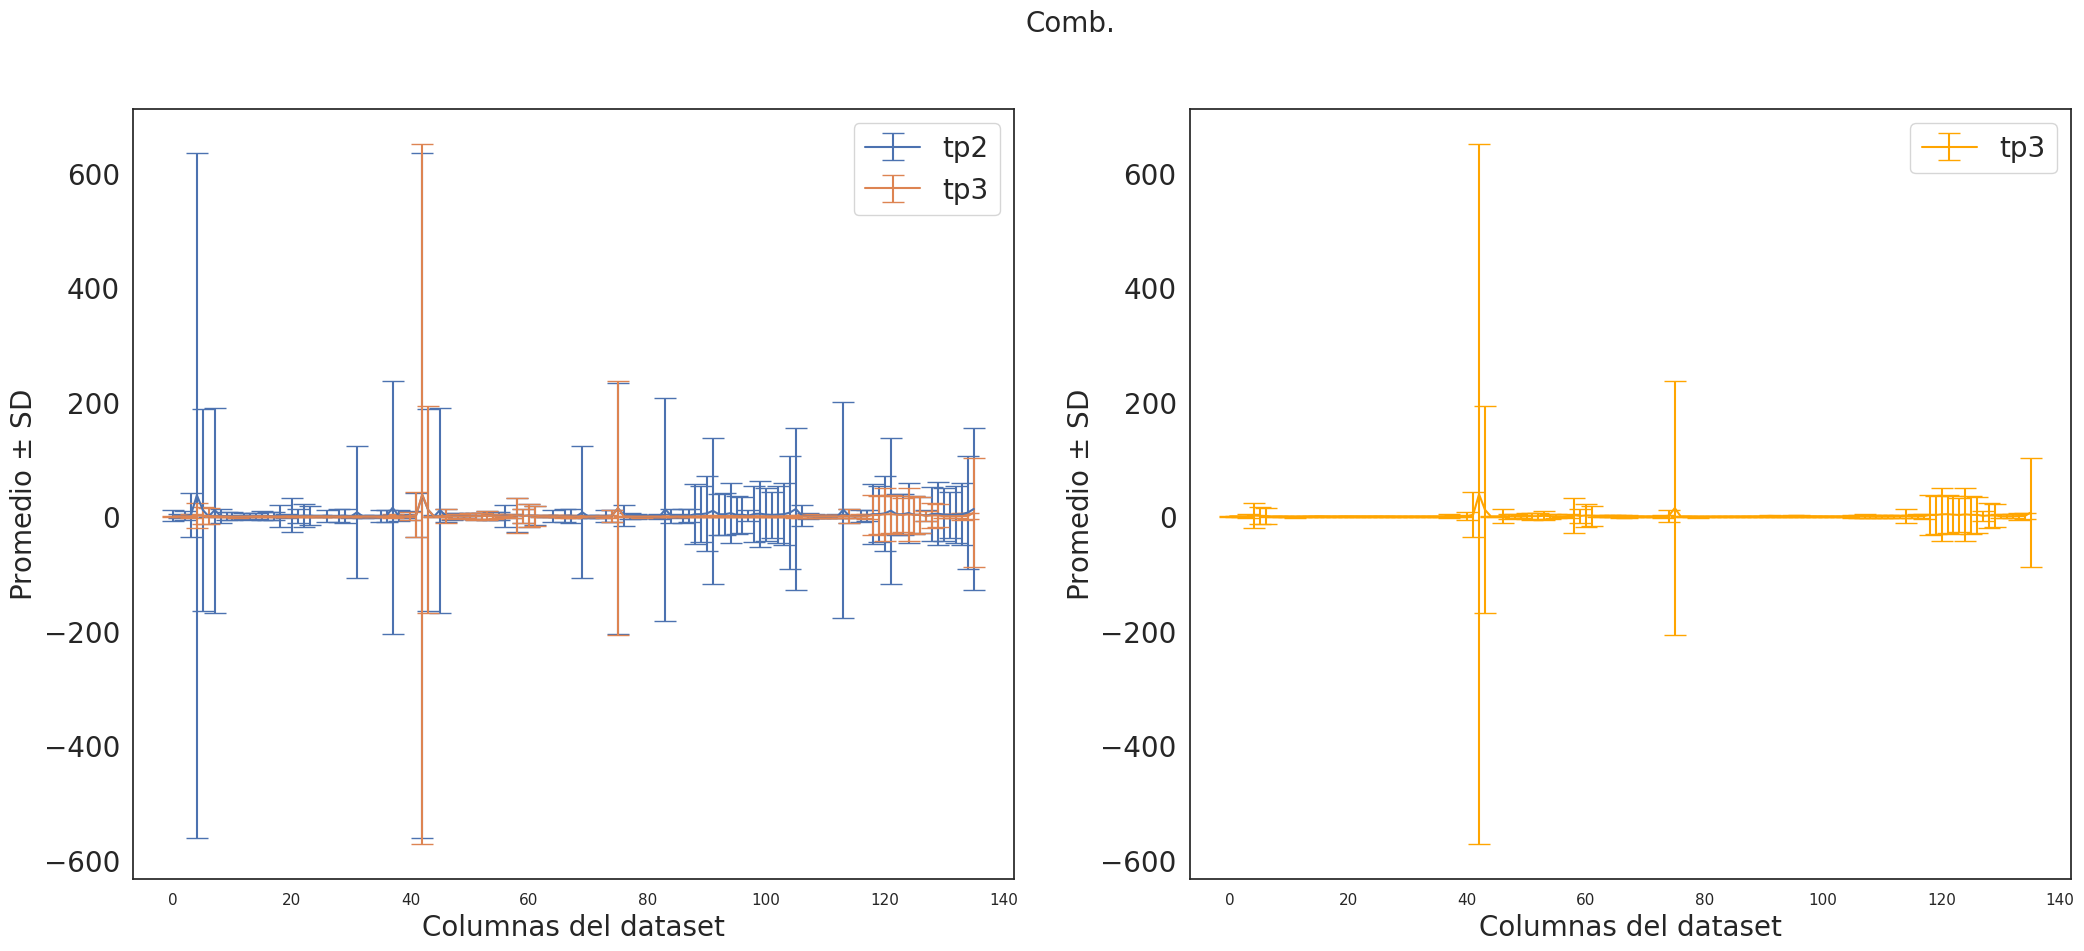

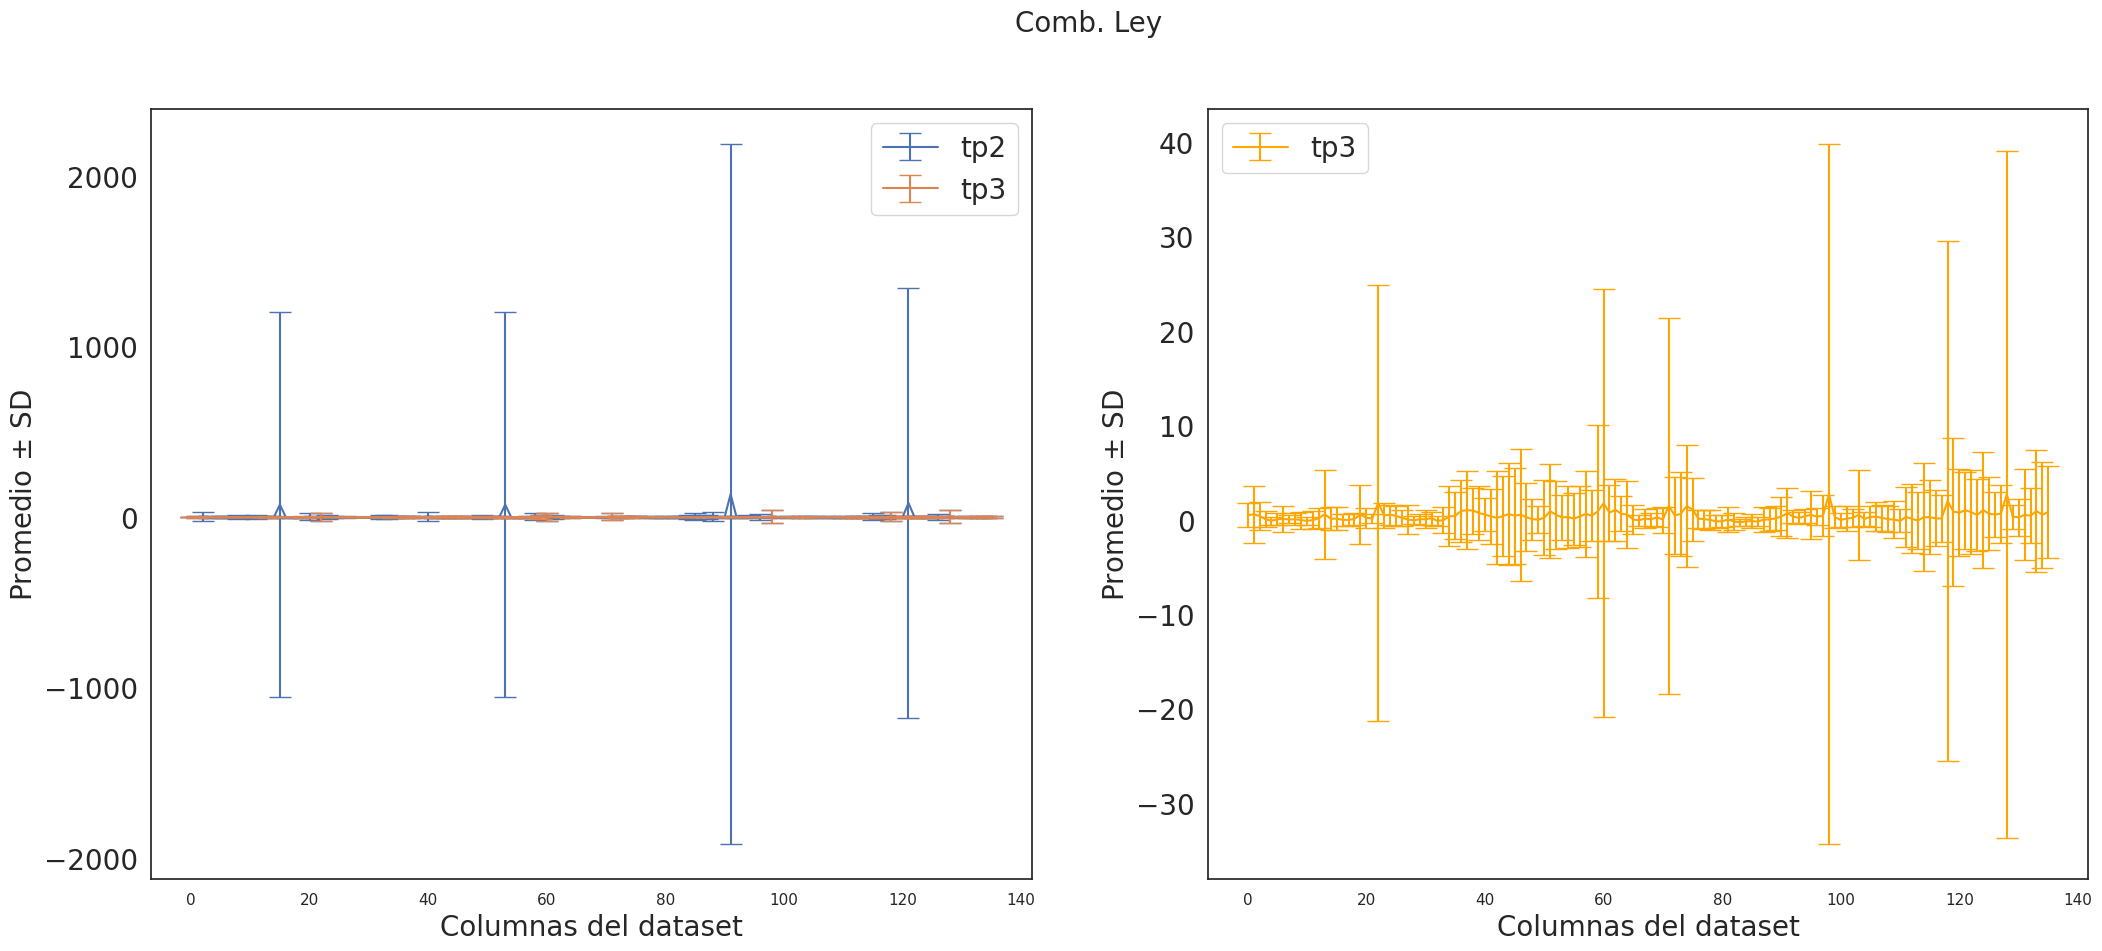

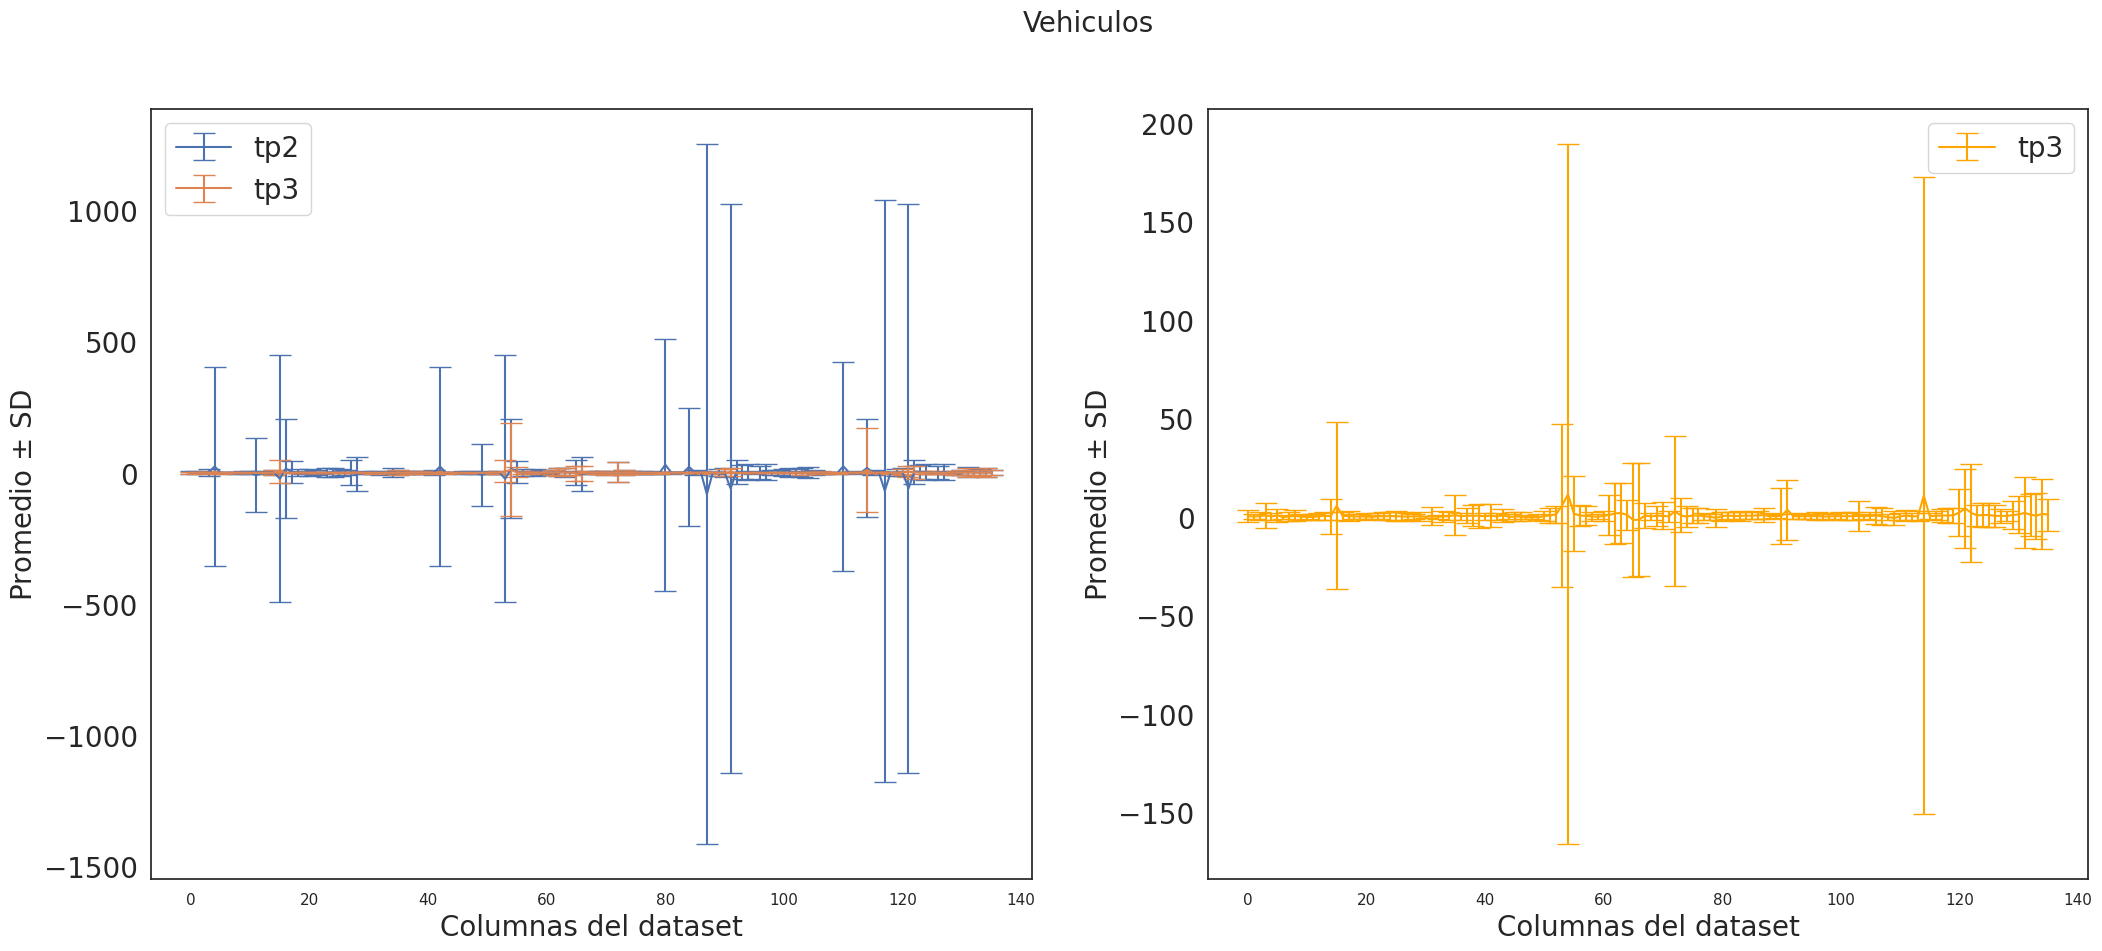

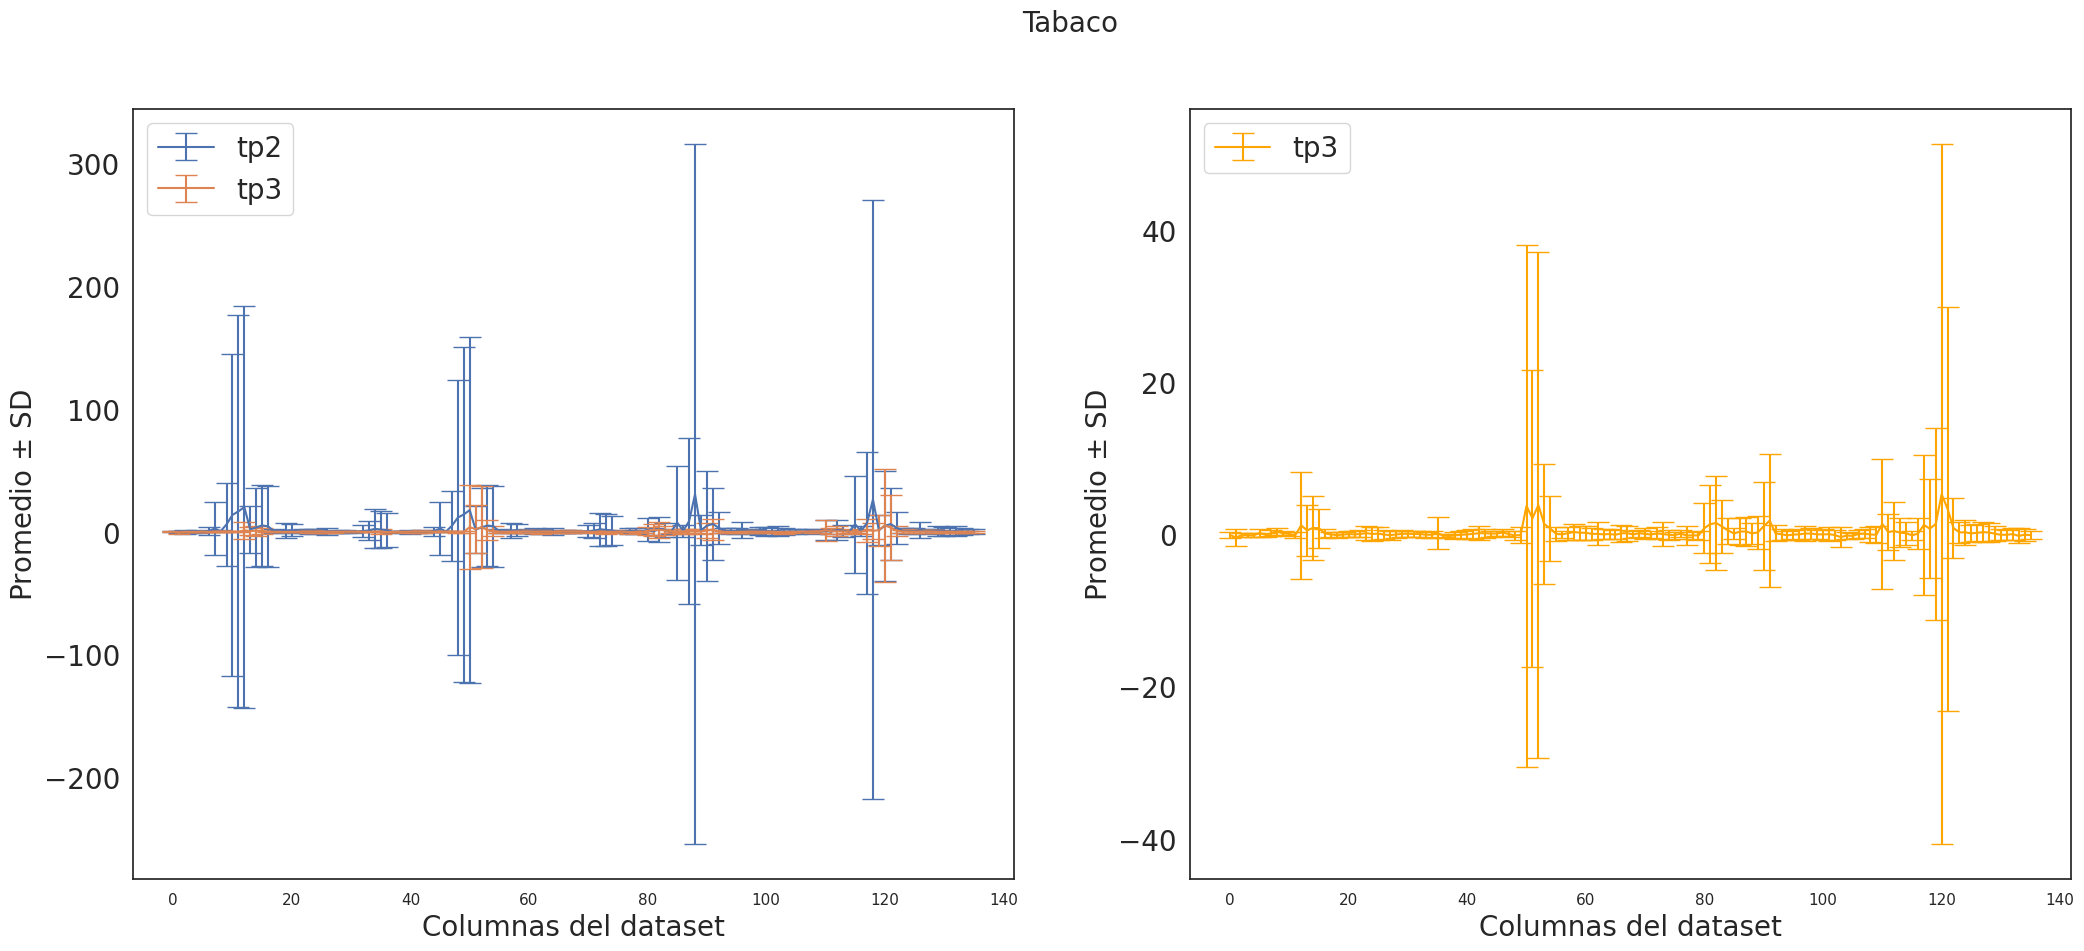

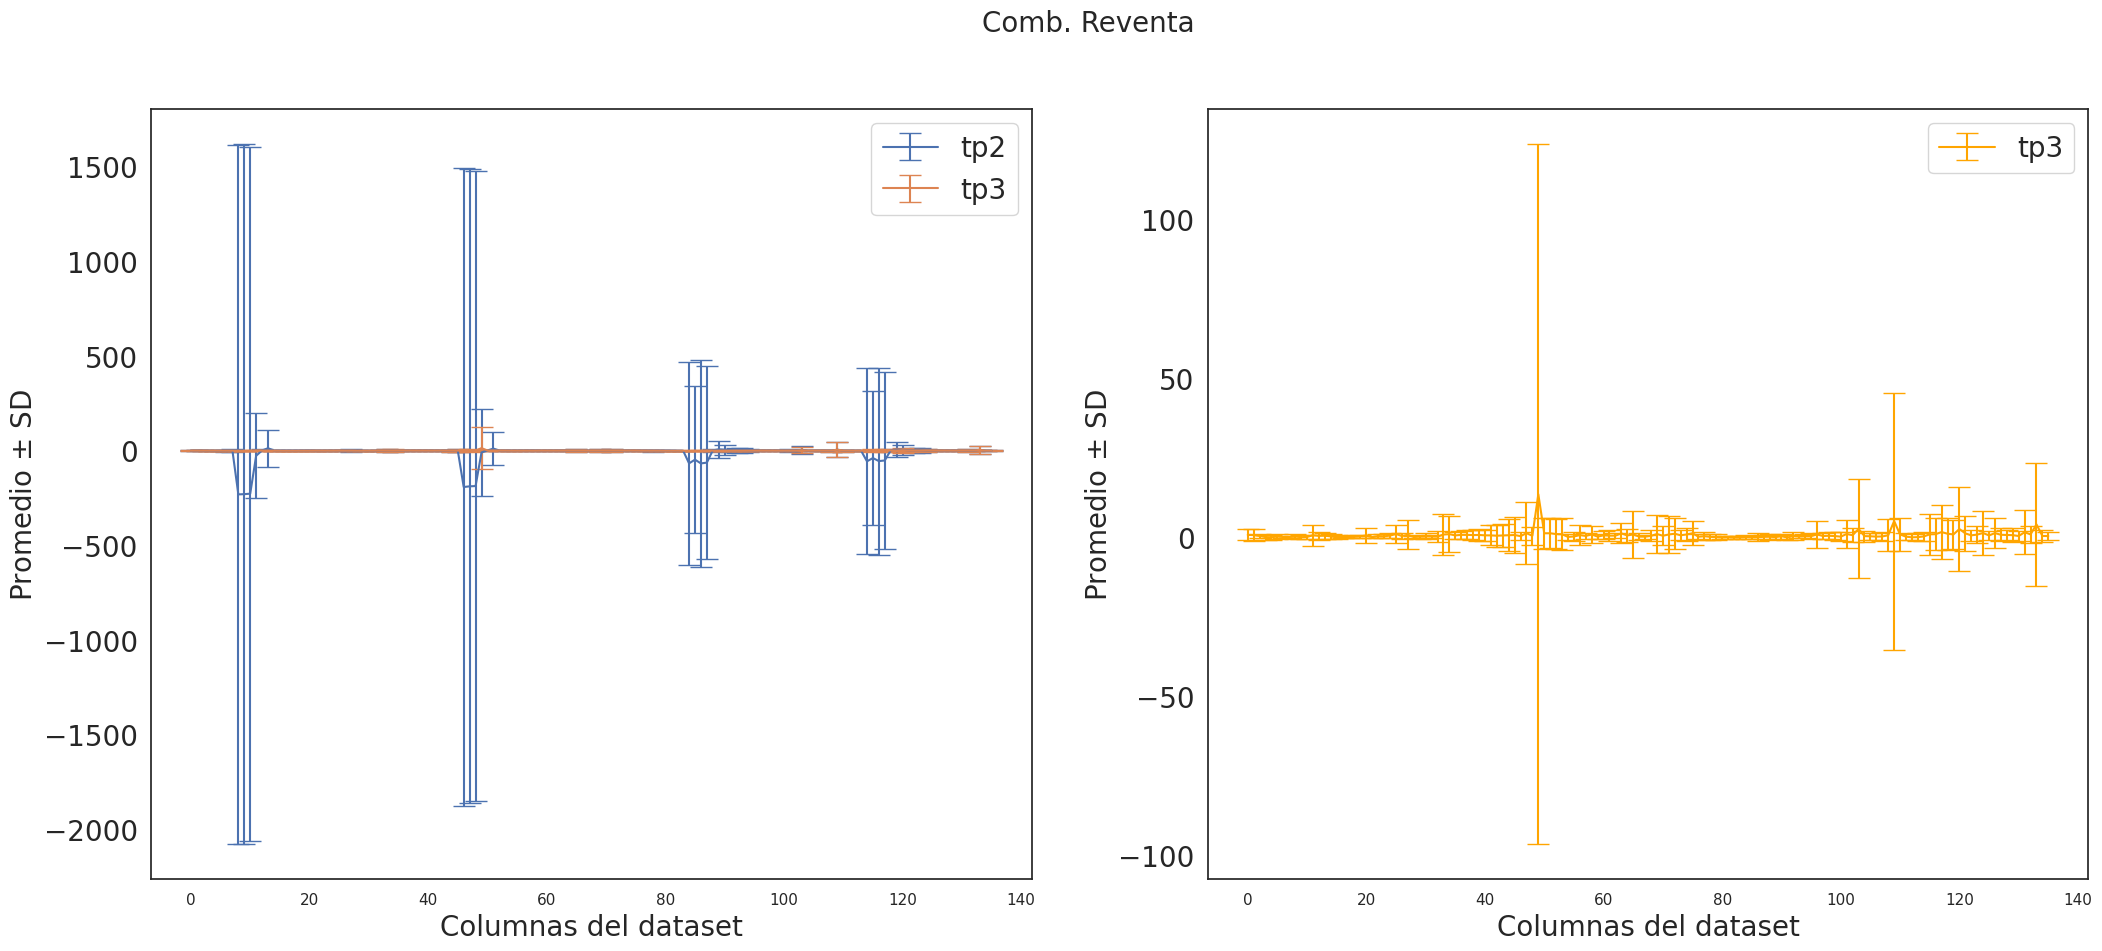

In [35]:
for sr in tp2.Subrubro.unique():

    tp2sr = tp2[tp2['Subrubro'] == sr].copy()
    tp3sr = tp3[tp3['Subrubro'] == sr].copy()

    fig, axs = plt.subplots(1, 2, figsize=(25, 10))

    fig.suptitle(sr, fontsize=20)

    axs[0].errorbar(range(len(tp2sr.iloc[:, 3:].mean())), tp2sr.iloc[:, 3:].mean(), yerr = tp2sr.iloc[:, 3:].std(), capsize = 8, label='tp2')
    axs[0].errorbar(range(len(tp3sr.iloc[:, 3:].mean())), tp3sr.iloc[:, 3:].mean(), yerr = tp3sr.iloc[:, 3:].std(), capsize = 8, label='tp3')
    axs[0].set_ylabel(r'Promedio $\pm$ SD', fontsize=20)
    axs[0].tick_params(axis='y', labelsize=20)
    axs[0].legend(fontsize=20)
    axs[0].set_xlabel('Columnas del dataset', fontsize=20)

    axs[1].errorbar(range(len(tp3sr.iloc[:, 3:].mean())), tp3sr.iloc[:, 3:].mean(), yerr = tp3sr.iloc[:, 3:].std(), capsize = 8, label='tp3', color='orange')
    axs[1].set_ylabel(r'Promedio $\pm$ SD', fontsize=20)
    axs[1].tick_params(axis='y', labelsize=20)
    axs[1].legend(fontsize=20)
    axs[1].set_xlabel('Columnas del dataset', fontsize=20)

    plt.show()